# Used Car Price Prediction

In [135]:
import os
from datetime import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS, add_constant

from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression, f_regression, RFE, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

np.random.seed(2024)

In [138]:
def save_my_figure(to_save, filename:str, extra_path:str='', add_datetime:bool=False, extension:str='png', dpi=None):
    current = datetime.now()
    current_date = current.strftime('%Y%m%d')
    # current_datetime = current.strftime('%Y%m%d_%H%M%S') # include hour, minute, and second
    # directory path
    dir_path = os.path.join(os.getcwd(), extra_path)
    os.makedirs(dir_path, exist_ok=True)
    # file name
    if add_datetime:
        filename = f'{filename}_{current_date}.{extension}' # include current date and time
    else:
        filename = f'{filename}.{extension}'
    save_path = os.path.join(dir_path, filename)
    # save figure
    try:
        to_save.savefig(save_path, dpi=dpi, bbox_inches='tight') # to save Matplotlib, Seaborn chart
    except:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    print('Saved:', save_path)

In [2]:
from IPython.display import display, HTML

# Function to display the full DataFrame
def print_all(df): 
    with pd.option_context('display.max_rows',None):
        with pd.option_context('display.max_columns',None):
            with pd.option_context('display.float_format', '{:,.4f}'.format):
                with pd.option_context('display.float_format', '{:,.4f}'.format): # print entre words in cell
                    # Show the number of rows and columns in the DataFrame
                    print(df.shape)
                    # Print the entire DataFrame
                    display(df)
# Function to display the first 'n' rows of the DataFrame with its all columns
def print_cols(df, n=5): 
    with pd.option_context('display.max_columns',None):
        with pd.option_context('display.float_format', '{:,.4f}'.format):
            # Show the number of rows and columns in the DataFrame
            print(df.shape)
            # Print the first 'n' rows of the DataFrame with all the columns
            display(df[:n])

In [3]:
# Read the CSV file into a DataFrame
train = pd.read_csv('data/train.csv', index_col=0) # id column -> index
print_cols(train, 2)

(188533, 12)


brand          model  model_year  milage fuel_type  \
id                                                         
0      MINI  Cooper S Base        2007  213000  Gasoline   
1   Lincoln          LS V8        2002  143250  Gasoline   

                                          engine transmission ext_col int_col  \
id                                                                              
0   172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel          A/T  Yellow    Gray   
1   252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel          A/T  Silver   Beige   

                                  accident clean_title  price  
id                                                             
0                            None reported         Yes   4200  
1   At least 1 accident or damage reported         Yes   4999

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


In [7]:
train.describe(include='all')

brand      model     model_year         milage fuel_type  \
count   188533     188533  188533.000000  188533.000000    183450   
unique      57       1897            NaN            NaN         7   
top       Ford  F-150 XLT            NaN            NaN  Gasoline   
freq     23088       2945            NaN            NaN    165940   
mean       NaN        NaN    2015.829998   65705.295174       NaN   
std        NaN        NaN       5.660967   49798.158076       NaN   
min        NaN        NaN    1974.000000     100.000000       NaN   
25%        NaN        NaN    2013.000000   24115.000000       NaN   
50%        NaN        NaN    2017.000000   57785.000000       NaN   
75%        NaN        NaN    2020.000000   95400.000000       NaN   
max        NaN        NaN    2024.000000  405000.000000       NaN   

                                              engine transmission ext_col  \
count                                         188533       188533  188533   
unique                                          1117           52     319   
top     355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel          A/T   Black   
freq                                            3462        49904   48658   
mean                                             NaN          NaN     NaN   
std                                              NaN          NaN     NaN   
min                                              NaN          NaN     NaN   
25%                                              NaN          NaN     NaN   
50%                                              NaN          NaN     NaN   
75%                                              NaN          NaN     NaN   
max                                              NaN          NaN     NaN   

       int_col       accident clean_title         price  
count   188533         186081      167114  1.885330e+05  
unique     156              2           1           NaN  
top      Black  None reported         Yes           NaN  
freq    107674         144514      167114           NaN  
mean       NaN            NaN         NaN  4.387802e+04  
std        NaN            NaN         NaN  7.881952e+04  
min        NaN            NaN         NaN  2.000000e+03  
25%        NaN            NaN         NaN  1.700000e+04  
50%        NaN            NaN         NaN  3.082500e+04  
75%        NaN            NaN         NaN  4.990000e+04  
max        NaN            NaN         NaN  2.954083e+06

In [5]:
# test = pd.read_csv('data/test.csv', index_col=0)
# print_cols(test, 2)

In [14]:
target_col = 'price'

# IDA/EDA

## Checking Missing Values

fuel_type       5083
accident        2452
clean_title    21419
dtype: int64


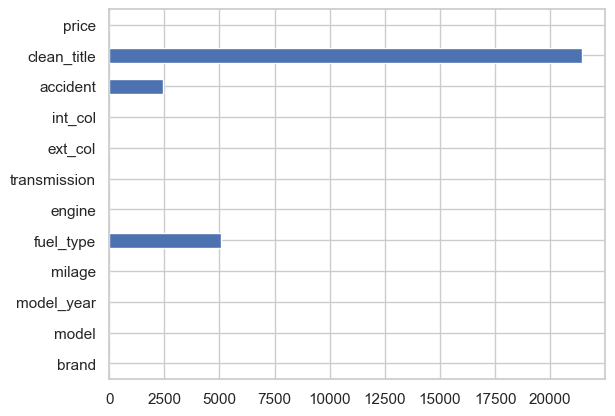

In [141]:
# Check for missing values in the DataFrame
temp = train.isna().sum() # Count missing values for each column
# Print the columns with missing values
print(temp[temp != 0])
# Create a horizontal bar plot for columns with missing values
temp.plot(kind='barh');

In [149]:
# fuel_type
train['fuel_type'].value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [60]:
# clean_title
X_train['clean_title'].value_counts()

clean_title
Yes    133692
Name: count, dtype: int64

In [61]:
# accident
X_train['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

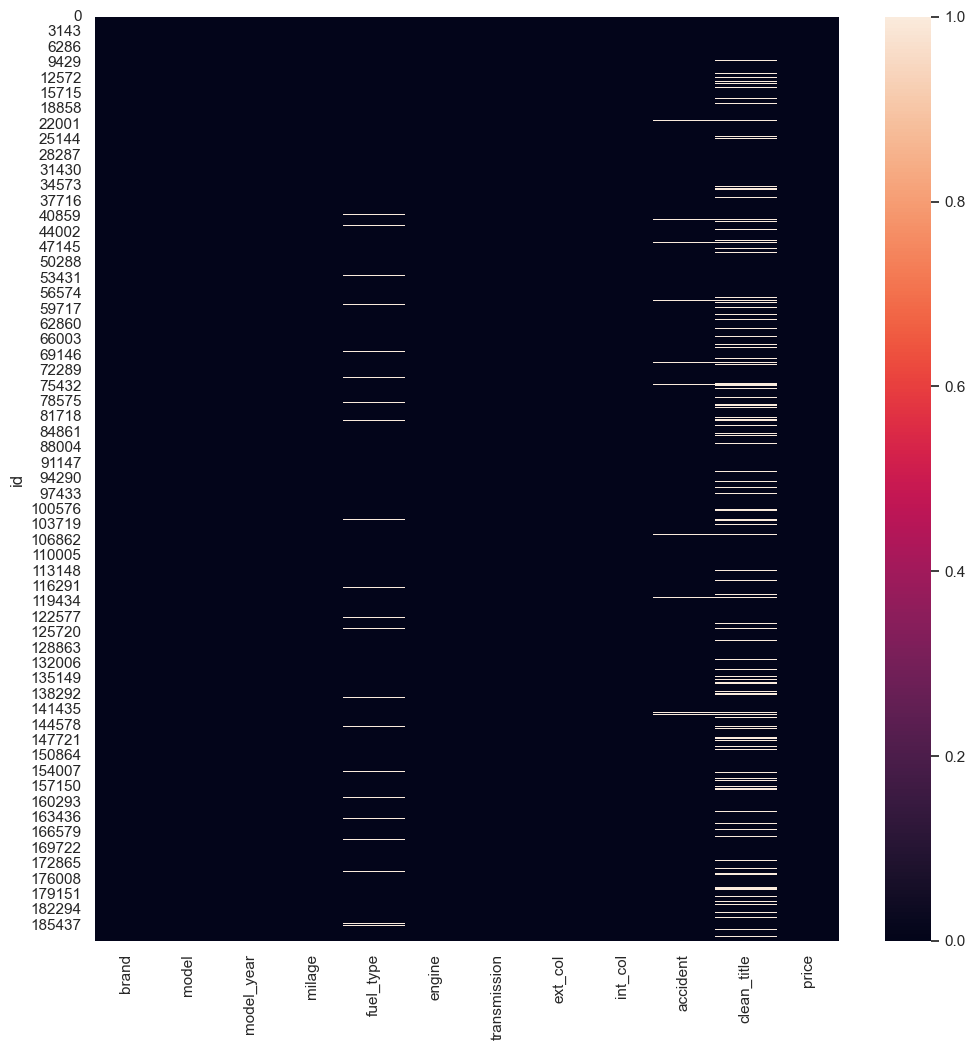

In [142]:
# missing values heatmap
plt.figure(figsize=(12,12))
sns.heatmap(train.isna())
plt.plot();

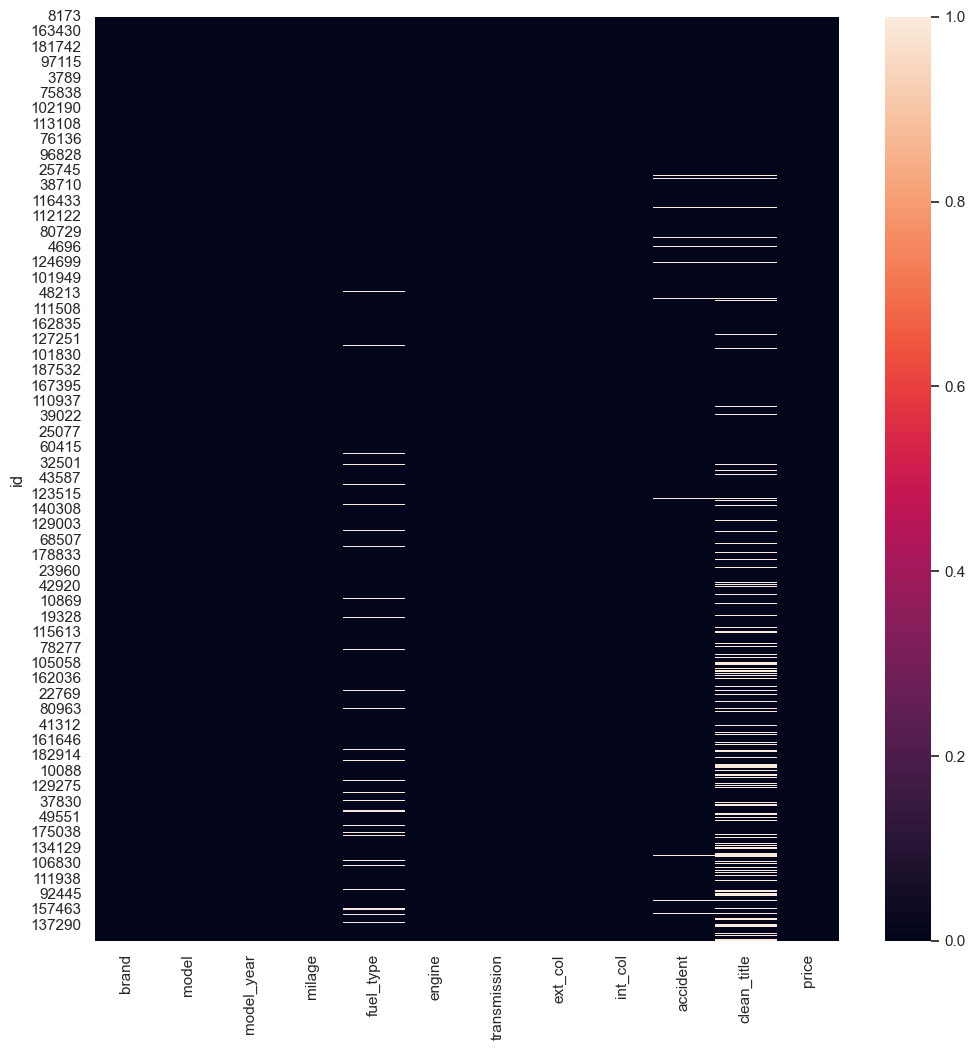

In [148]:
# missing values heatmap (sorted by model year)
# to see if missing values are correlated with years
plt.figure(figsize=(12,12))
sns.heatmap(train.sort_values('model_year', ascending=True).isna()) # sorted by model year
plt.plot();

In [78]:
# Column names with missing values
null_cols = train.columns[train.isna().any(axis=0)].tolist()
null_cols

['fuel_type', 'accident', 'clean_title']

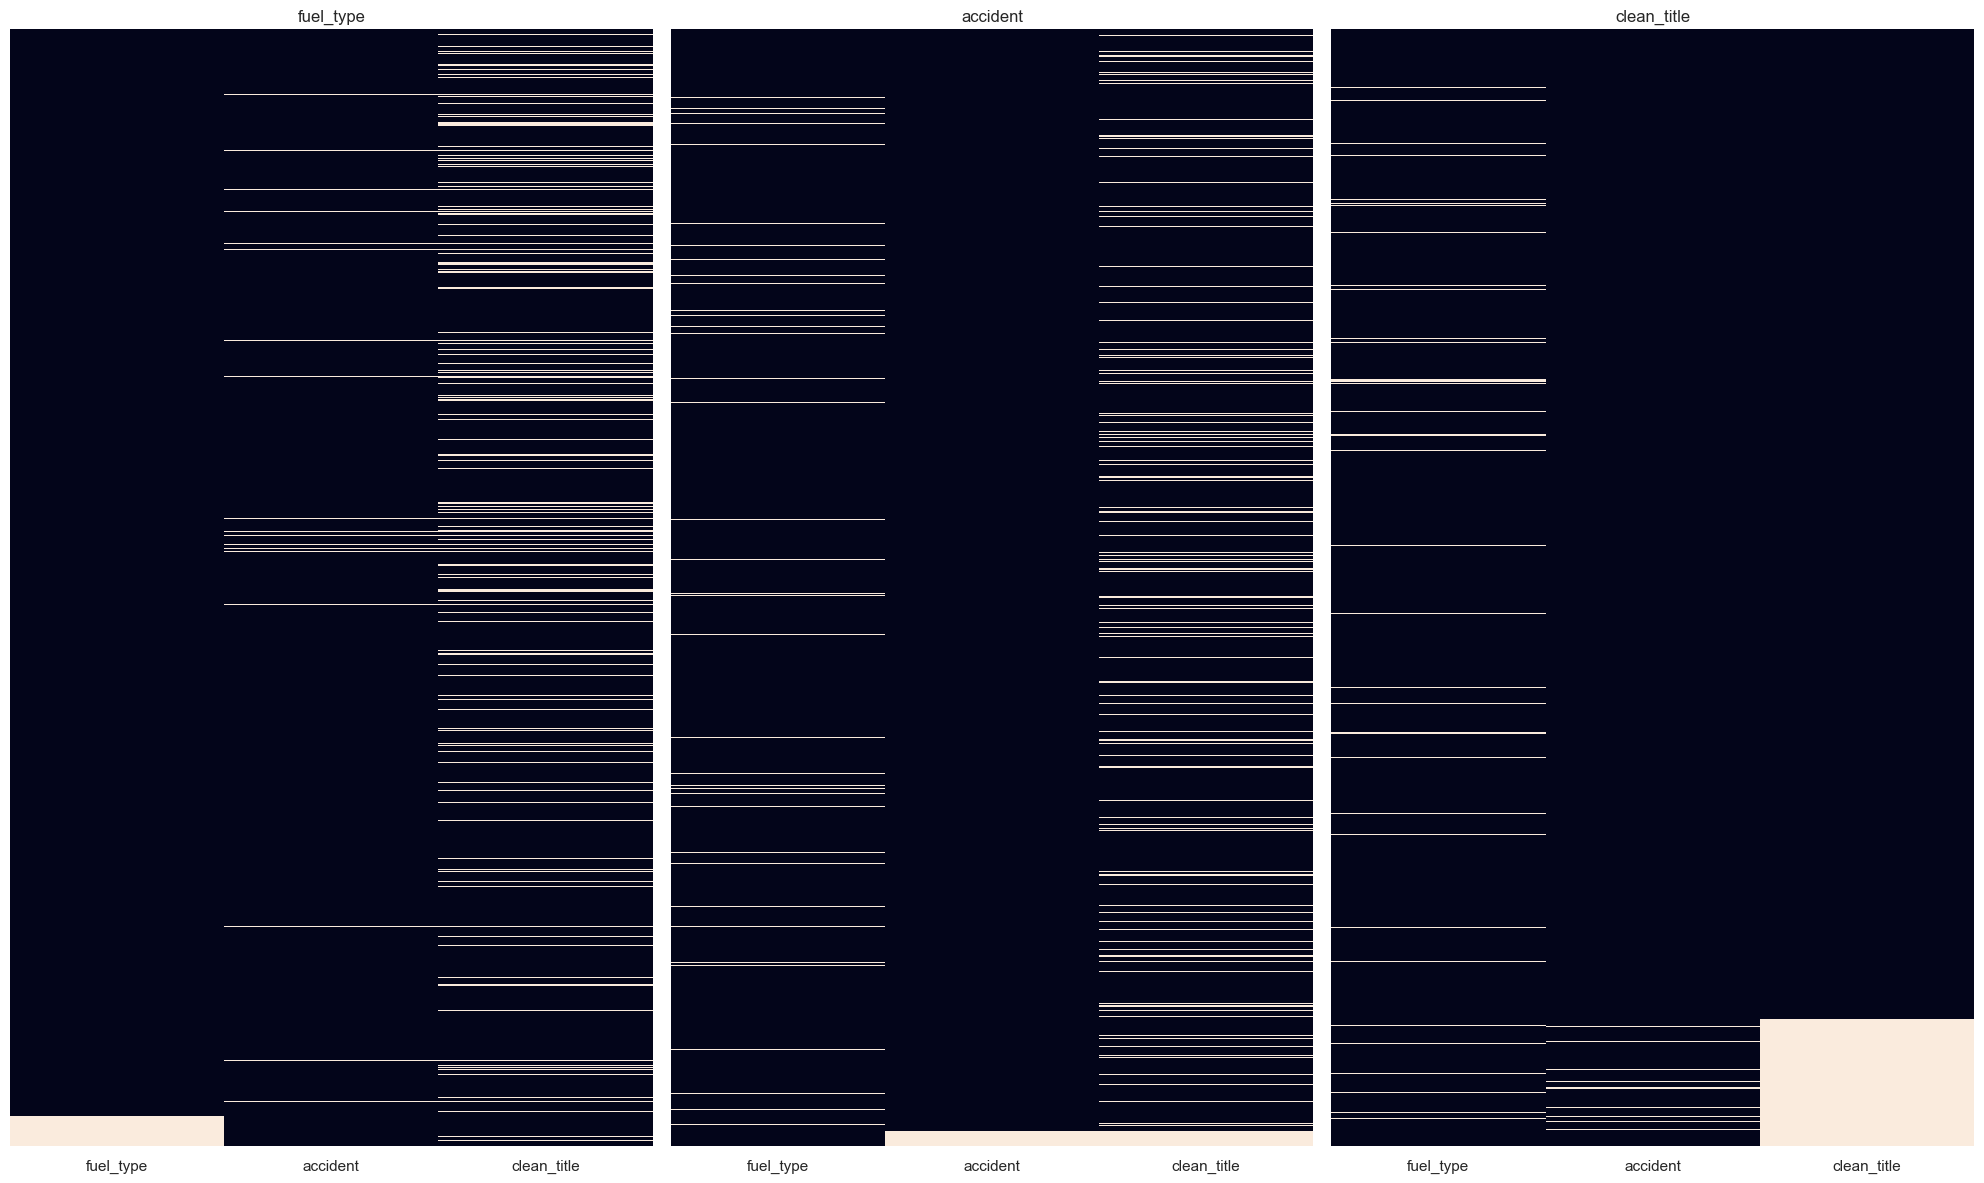

In [178]:
# Set up the plotting layout (3 plots side by side)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 12))

# Plot heatmap for 'fuel_type'
sns.heatmap(train[null_cols].isna().sort_values('fuel_type'), ax=ax1, cbar=False)
ax1.set_yticks([]) # No y ticks
ax1.set_ylabel('') # No y labels
ax1.set_title('fuel_type')

# Plot heatmap for 'accident'
sns.heatmap(train[null_cols].isna().sort_values('accident'), ax=ax2, cbar=False)
ax2.set_yticks([])
ax2.set_ylabel('')
ax2.set_title('accident')

# Plot heatmap for 'clean_title'
sns.heatmap(train[null_cols].isna().sort_values('clean_title'), ax=ax3, cbar=False)
ax3.set_yticks([])
ax3.set_ylabel('')
ax3.set_title('clean_title')

plt.tight_layout()
plt.show()

- The variable 'fuel_type' has random missing values.
- Or, it could have relations with other variables (not accident or clean_title)
- The variables 'clean_title' and 'accident' seem to have some relations with each other in having missing values.

## Distribution
- Numerical variables distribution

In [4]:
# numerical columns list
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols

['model_year', 'milage', 'price']

model_year 분포 통계:
min: 1974.00
max: 2024.00
mean: 2015.83
median: 2017.00
25%: 2013.00
75%: 2020.00
Skewness: -1.0445111735348063
Kurtosis: 0.7493011634168636


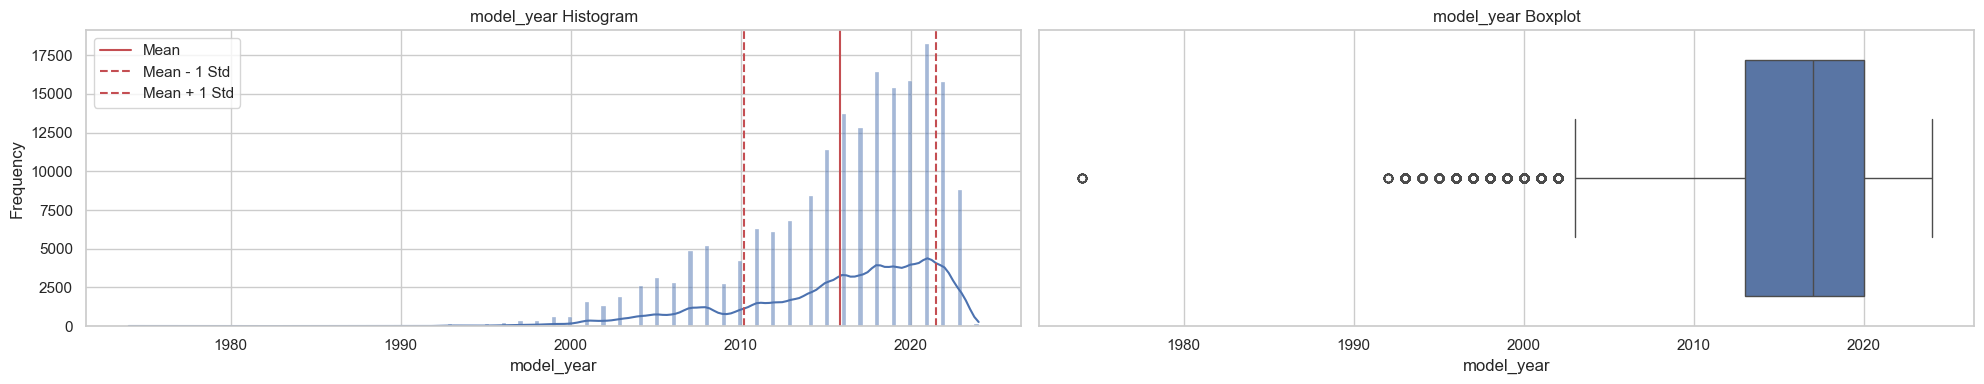

milage 분포 통계:
min: 100.00
max: 405000.00
mean: 65705.30
median: 57785.00
25%: 24115.00
75%: 95400.00
Skewness: 0.8950620098363095
Kurtosis: 0.6782410620850401


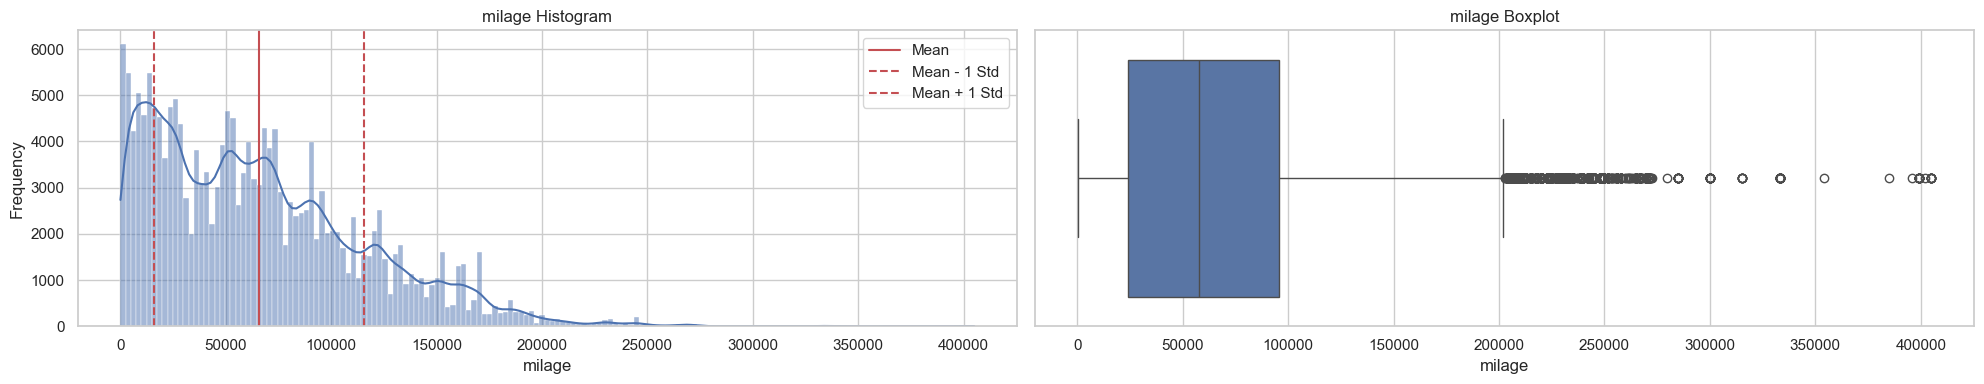

price 분포 통계:
min: 2000.00
max: 2954083.00
mean: 43878.02
median: 30825.00
25%: 17000.00
75%: 49900.00
Skewness: 20.268452710951134
Kurtosis: 623.9653424058328


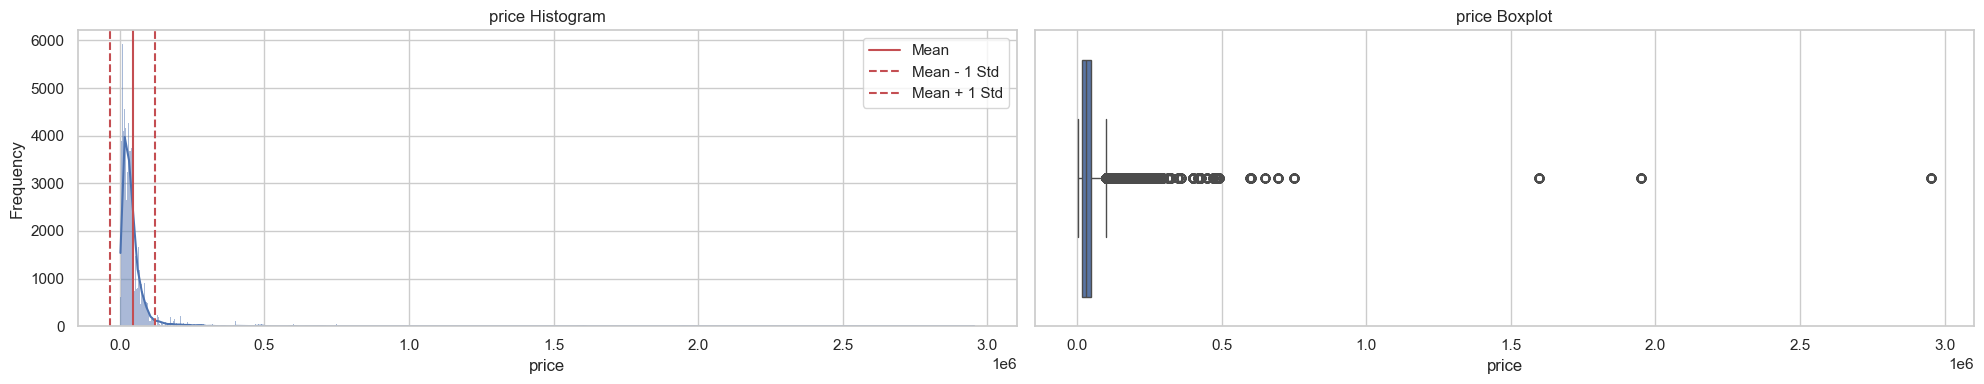

In [252]:
# Function to plot distribution of a numerical column
def plot_dist(df, column):
    series = df[column]
    # Basic statistics for the column
    stats = {
        'min': series.min(), # Minimum value
        'max': series.max(), # Maximum value
        'mean': series.mean(), # Mean (average) value
        'median': series.median(), # Median value
        '25%': series.quantile(0.25), # 25th percentile (1st quartile)
        '75%': series.quantile(0.75) # 75th percentile (3rd quartile)
    }
    print(f"{column} distribution statistics:")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")
    
    # Plot 1: Visualize the data distribution (histogram)
    plt.figure(figsize=(20, 4))
    plt.subplot(121)
    sns.histplot(series, kde=True) # Plot the histogram with a KDE (Kernel Density Estimate)
    plt.title(f'{column} Histogram')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Add lines for the normal distribution boundaries (mean and standard deviation)
    mean, std = series.mean(), series.std() # Calculate the mean and standard deviation
    plt.axvline(mean, color='r', linestyle='-', label='Mean') # Line for the mean
    plt.axvline(mean - std, color='r', linestyle='--', label='Mean - 1 Std') # Line for mean - 1 standard deviation
    plt.axvline(mean + std, color='r', linestyle='--', label='Mean + 1 Std') # Line for mean + 1 standard deviation
    plt.legend()
    
    # Check the skewness and kurtosis of the distribution
    print("Skewness:", series.skew()) # Print skewness (asymmetry of the distribution)
    print("Kurtosis:", series.kurtosis()) # Print kurtosis (tailedness of the distribution)
    
    # Plot 2: Visualize the data distribution (boxplot)
    plt.subplot(122)
    sns.boxplot(x=series) # Plot the boxplot
    plt.title(f'{column} Boxplot')
    
    plt.tight_layout()
    plt.show()

# Loop through each numeric column and plot its distribution
for col in numeric_cols:
    plot_dist(train, col)

## Checking Outlier

1) IQR
- a measure of statistical dispersion, which indicates the spread of the middle 50% of your data
- calculated as the difference between the third quartile (Q3) and the first quartile (Q1)

In [7]:
# IQR

# Calculate the first quartile (Q1) and the third quartile (Q3) for each numeric column
Q1 = train[numeric_cols].quantile(0.25)  # Q1 is the 25th percentile
Q3 = train[numeric_cols].quantile(0.75)  # Q3 is the 75th percentile

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1 # difference between Q3 and Q1

# Define the condition for outliers using the IQR rule (1.5 * IQR below Q1 or above Q3)
cond = (train[numeric_cols] < (Q1 - 1.5 * IQR)) | (train[numeric_cols] > (Q3 + 1.5 * IQR))
temp = train[numeric_cols][cond].copy() # Select the rows where outliers are found
# Filter out rows where any column contains an outlier
outliers = temp[temp.any(axis=1)]
outliers

model_year    milage     price
id                                    
0              NaN  213000.0       NaN
1           2002.0       NaN       NaN
2           2002.0       NaN       NaN
10             NaN  212500.0       NaN
28             NaN  244200.0       NaN
...            ...       ...       ...
188479      2002.0       NaN       NaN
188485         NaN       NaN  115000.0
188501         NaN       NaN  129000.0
188523         NaN  239000.0       NaN
188527      1999.0       NaN       NaN

[17326 rows x 3 columns]

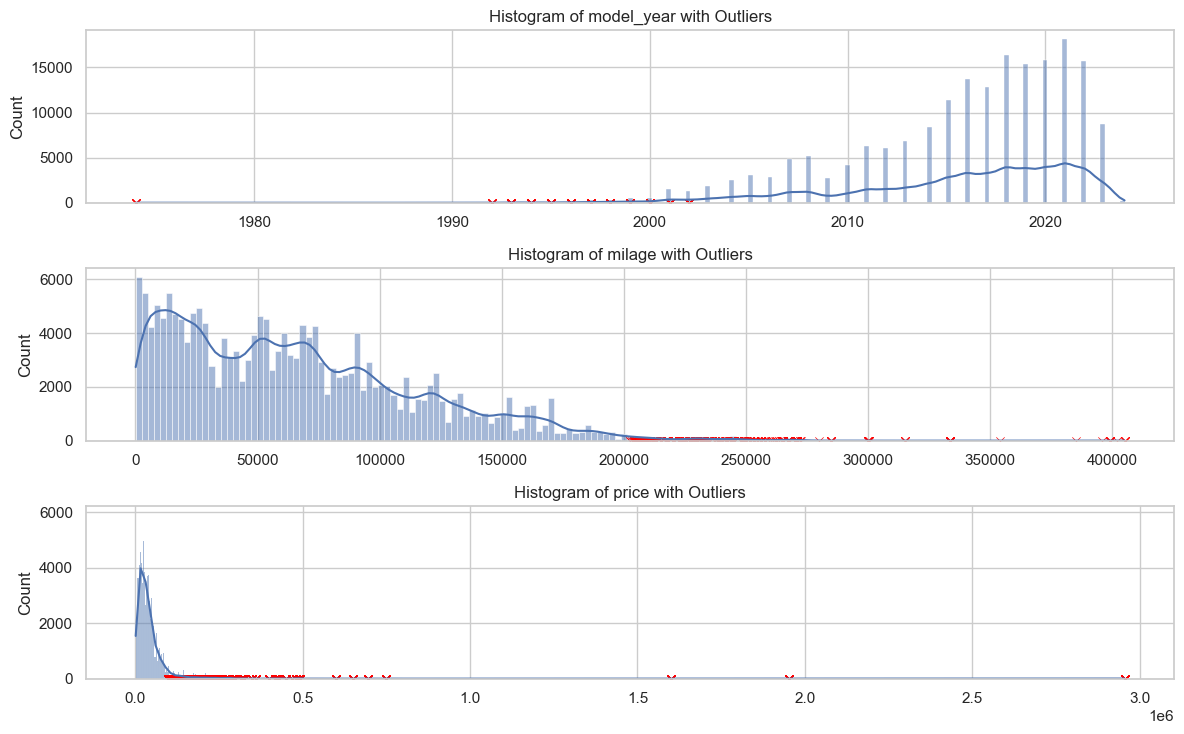

In [251]:
# Histogram with outliers (IQR) highlighted
fig, axes = plt.subplots(nrows=len(numeric_cols), figsize=(12, 2.5*len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    # Plot histogram with Kernel Density Estimate (KDE) on the same plot
    sns.histplot(data=train, x=col, ax=axes[i], kde=True)
    # Highlight outliers by overlaying them on the histogram with a different color
    sns.scatterplot(data=outliers, x=col, y=[0]*len(outliers), color='red', marker='x', ax=axes[i]) # Colorcode the outliers with a different color
    axes[i].set_title(f'Histogram of {col} with Outliers')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

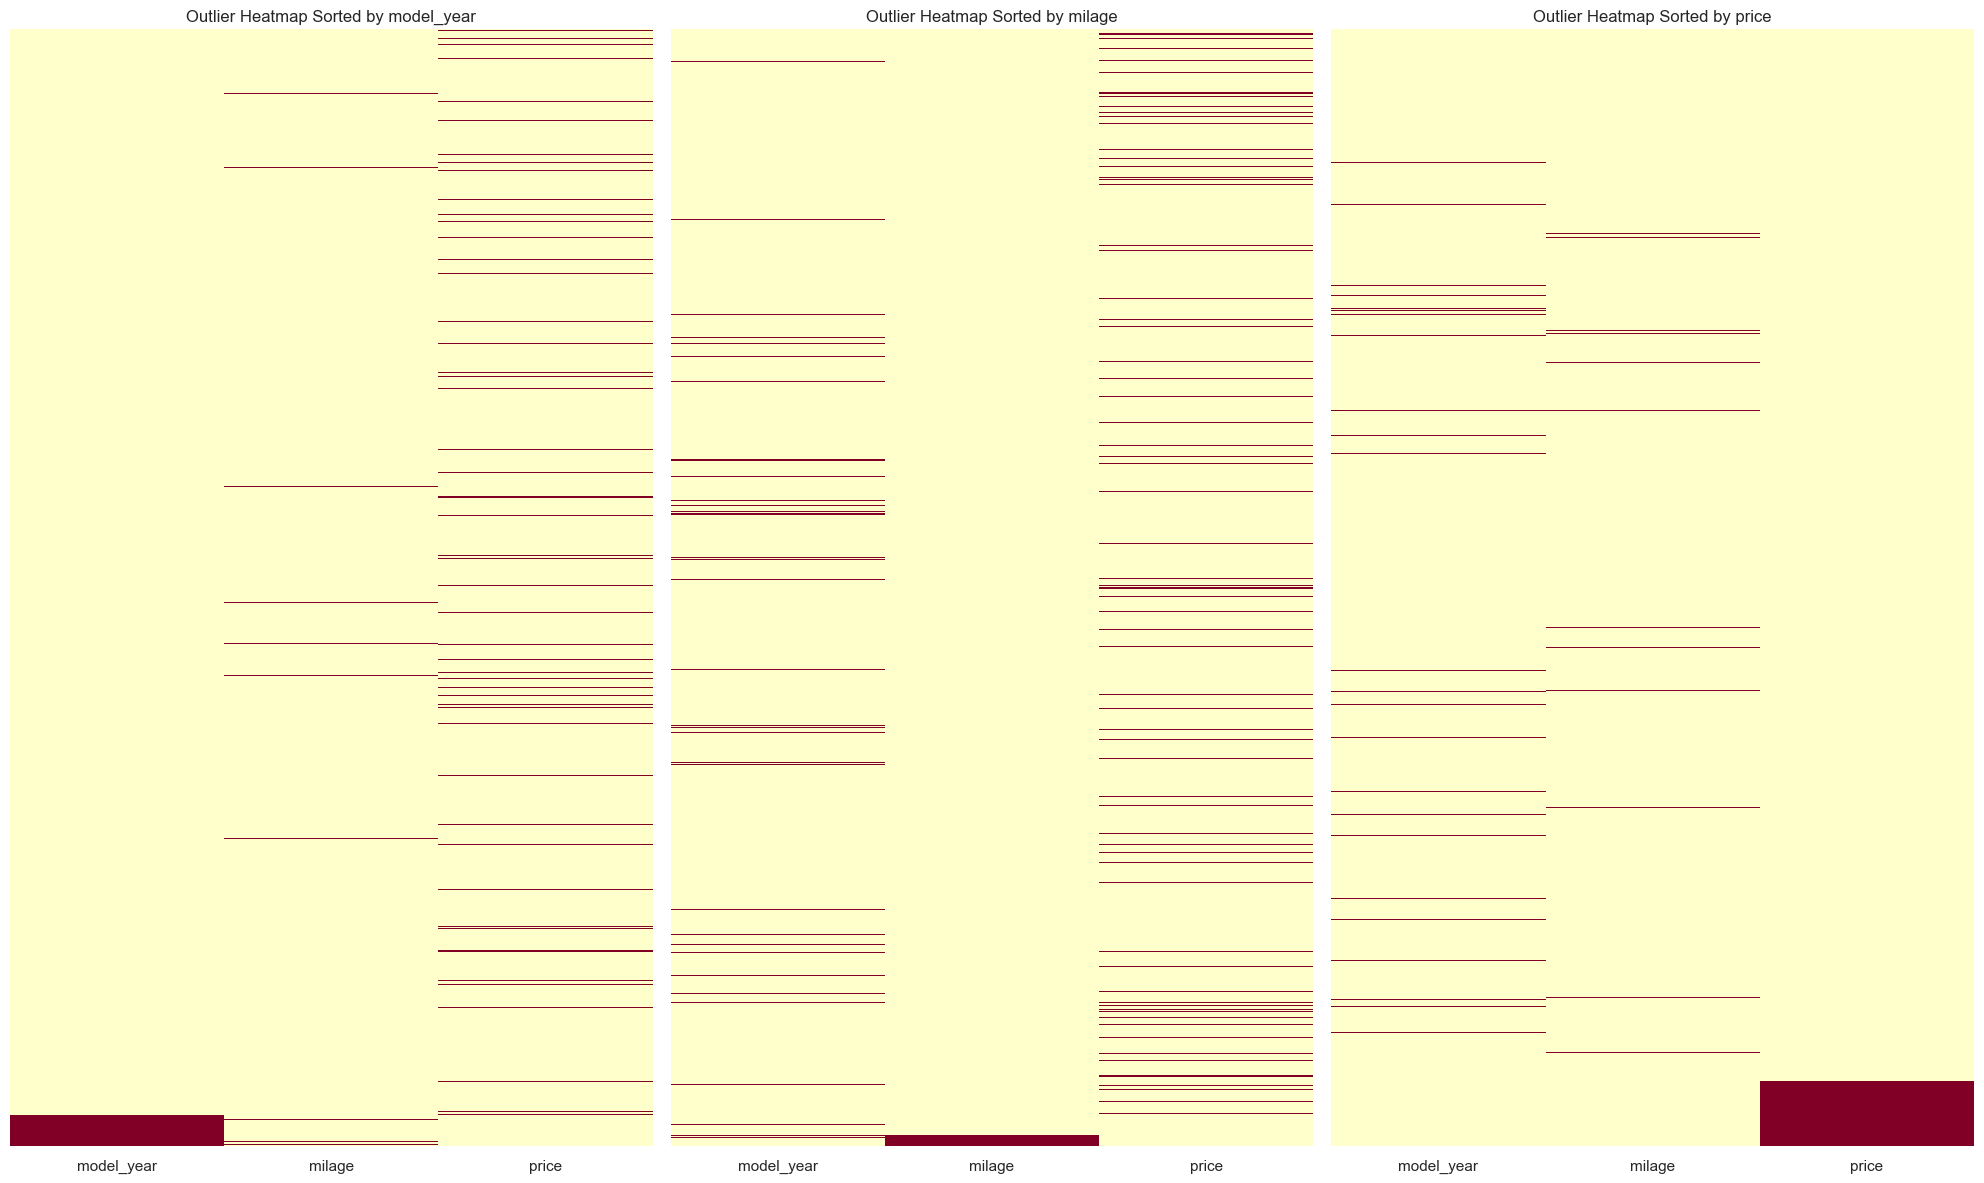

In [236]:
# Heatmaps for outliers (IQR)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 12))

# Heatmap for 'model_year' column sorted in ascending order
sns.heatmap(cond.sort_values('model_year'), cmap='YlOrRd', ax=ax1, cbar=False)
ax1.set_yticks([]) # Remove y-axis ticks
ax1.set_ylabel('') # Remove y-axis label
ax1.set_title('Outlier Heatmap Sorted by model_year')

# Heatmap for 'milage' column sorted in ascending order
sns.heatmap(cond.sort_values('milage'), cmap='YlOrRd', ax=ax2, cbar=False)
ax2.set_yticks([])
ax2.set_ylabel('')
ax2.set_title('Outlier Heatmap Sorted by milage')

# Heatmap for 'price' column sorted in ascending order
sns.heatmap(cond.sort_values('price'), cmap='YlOrRd', ax=ax3, cbar=False)
ax3.set_yticks([])
ax3.set_ylabel('')
ax3.set_title('Outlier Heatmap Sorted by price')

plt.tight_layout()
plt.show();

### 2) Cook's Distance
- In regression analysis, Cook's Distance is used to assess how much each observation affects the overall regression results.
- Typically, an observation is considered an outlier if its Cook's Distance value is greater than 4/n (where n is the total number of observations).
- After setting the independent and dependent variables, fit the regression model and calculate Cook's Distance for each observation.

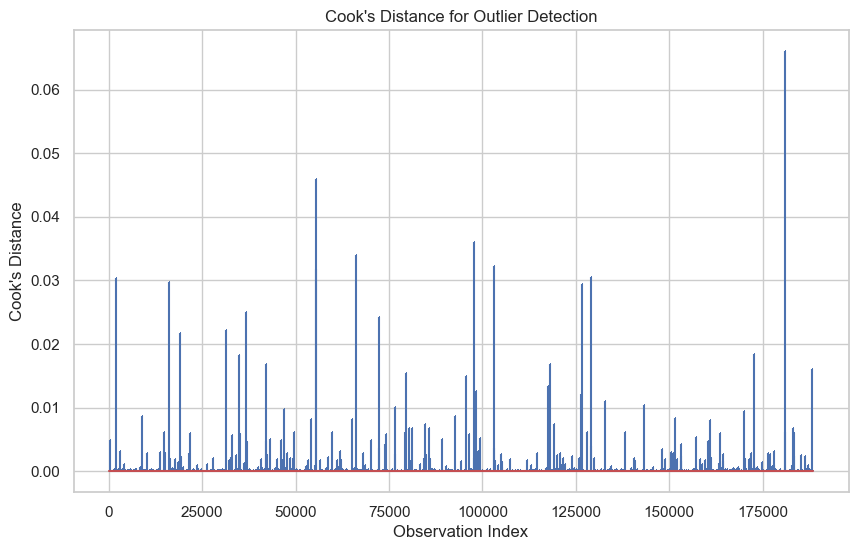

Detected outliers at indices: [    43    220    267 ... 188194 188285 188476]


In [185]:
# Set independent variables (X) and dependent variable (y)
X = train[numeric_cols].drop(columns=['price']).copy()
y = train['price'].copy()

# Add constant term (intercept) to the independent variables for regression
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit() # Ordinary Least Squares (OLS)

# Calculate Cook's Distance
influence = model.get_influence() # Get influence measures from the fitted model
cooks_d = influence.cooks_distance[0] # Get Cook's Distance values for each observation

# Visualize Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",") # Create a stem plot of Cook's Distance
plt.title("Cook's Distance for Outlier Detection")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

# Detect outliers (Typically, observations with Cook's Distance > 4/n are considered outliers)
n = len(train) # Total number of observations in the training set
outliers = np.where(cooks_d > 4/n)[0] # Find indices where Cook's Distance is greater than 4/n
print(f"Detected outliers at indices: {outliers}") # Print the indices of detected outliers

In [9]:
# check the outliers
print(len(outliers))
train.iloc[outliers][numeric_cols]

2846


model_year  milage    price
id                                 
43            2022   10972   244896
220           2021   26315  2954083
267           2017  127600   315000
283           2023    7578   267950
296           2020   44300   489000
...            ...     ...      ...
188186        2020    3158   238900
188192        2016   87500   324995
188194        2004   24915  1950995
188285        2019    2922   259000
188476        2020   88949   267950

[2846 rows x 3 columns]

## Numerical
- Correlation between numerical variabels
- Correlation with target variable

<Figure size 1000x800 with 0 Axes>

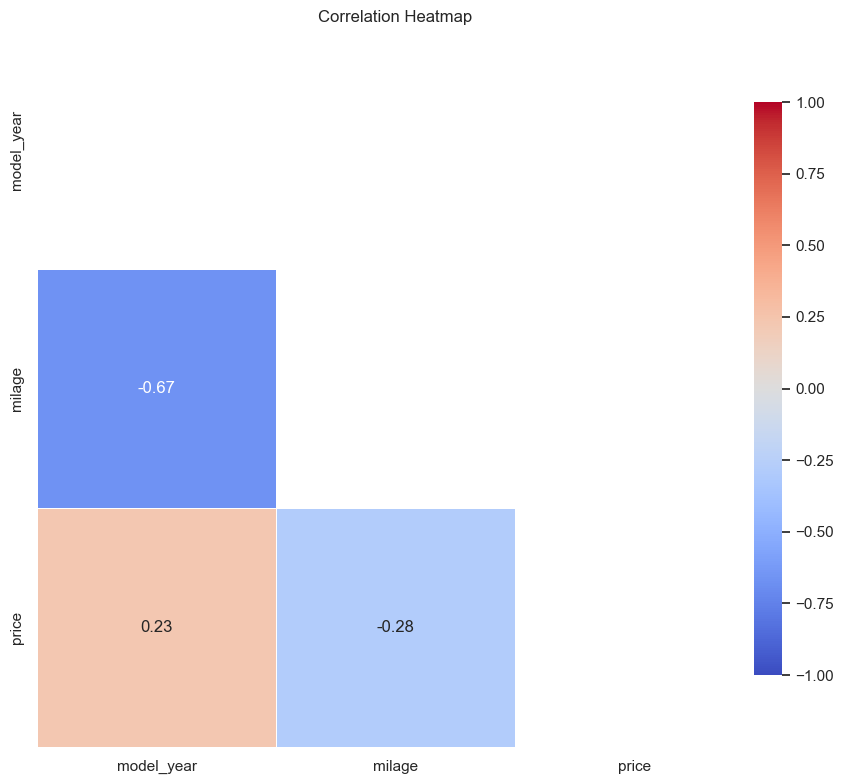

In [203]:
# Pairplot to visualize relationships between features
plt.figure(figsize=(10, 8))
sns.pairplot(train) # Create a pairplot of the train dataset
plt.show();

# Create a mask for the upper triangle of the correlation matrix and diagonal elements
corr = train.corr(numeric_only=True) # Calculate the correlation matrix of the train dataset
mask = np.triu(np.ones_like(corr, dtype=bool)) # Generate a mask for the upper triangle and diagonal

# Plot the heatmap using the correlation matrix, with the mask applied
plt.figure(figsize=(10, 8), facecolor='none')
sns.heatmap(corr,
            annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1, # Set the color scale range from -1 to 1
            mask=mask, # Apply the mask to only show the lower triangle of the correlation matrix
            square=True, # Ensure the heatmap is square-shaped
            cbar_kws={"shrink": .8, "pad": 0}, # Adjust the color bar size
            linewidths=.5) # Set the line width between heatmap cells

plt.title('Correlation Heatmap')
plt.grid(False)
plt.tight_layout()
plt.show();

## Categorical
- EDA on categorical variables
- Correlation with target variable

--- EDA for brand ---
Column 'brand' has too many unique values (57). Consider binning or filtering.
Unique values and counts for brand (Top 20):
Missing values for brand: 0
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/unique_values_count_brand_20241206.png


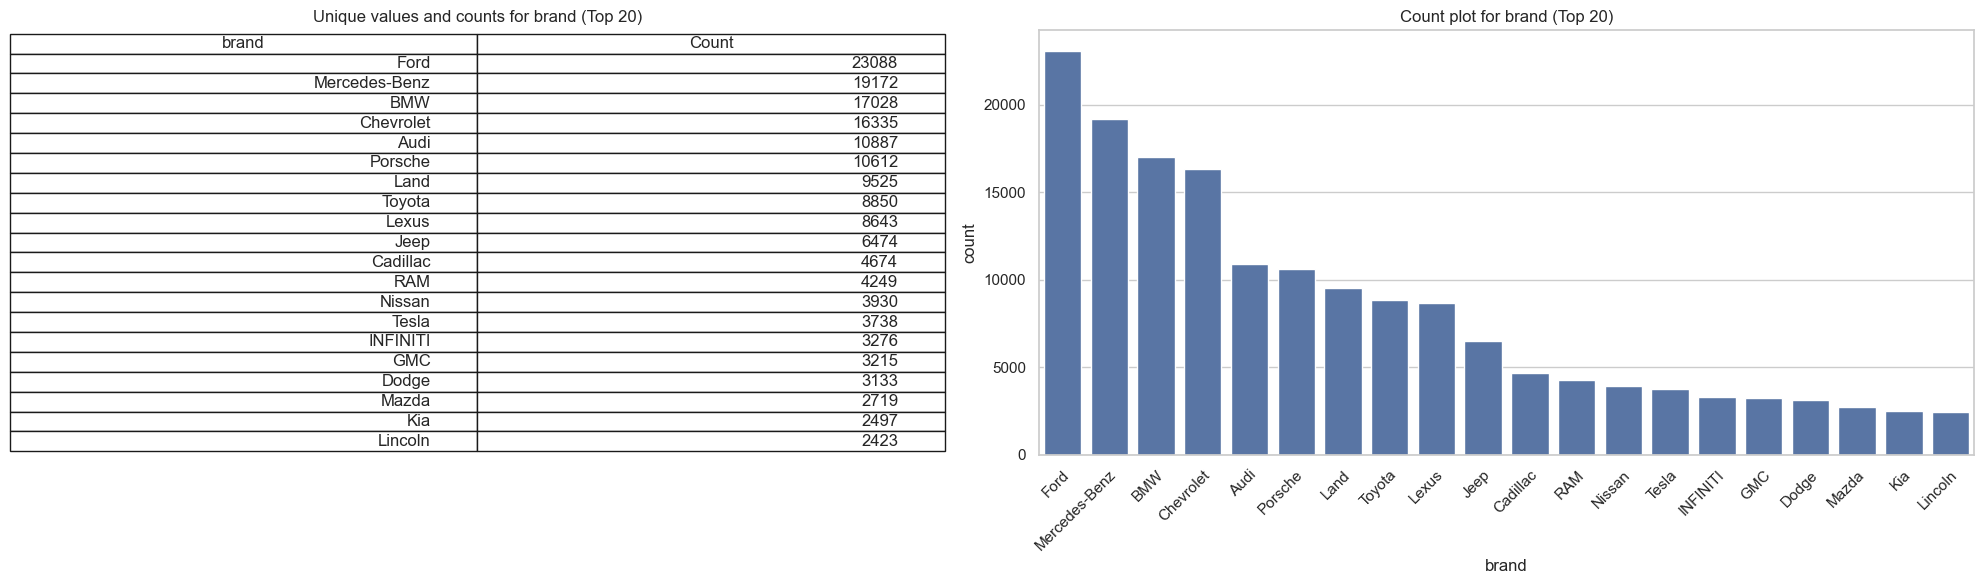

Analyzing relationship between 'brand' and 'price'...
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_mean_brand_20241206.png


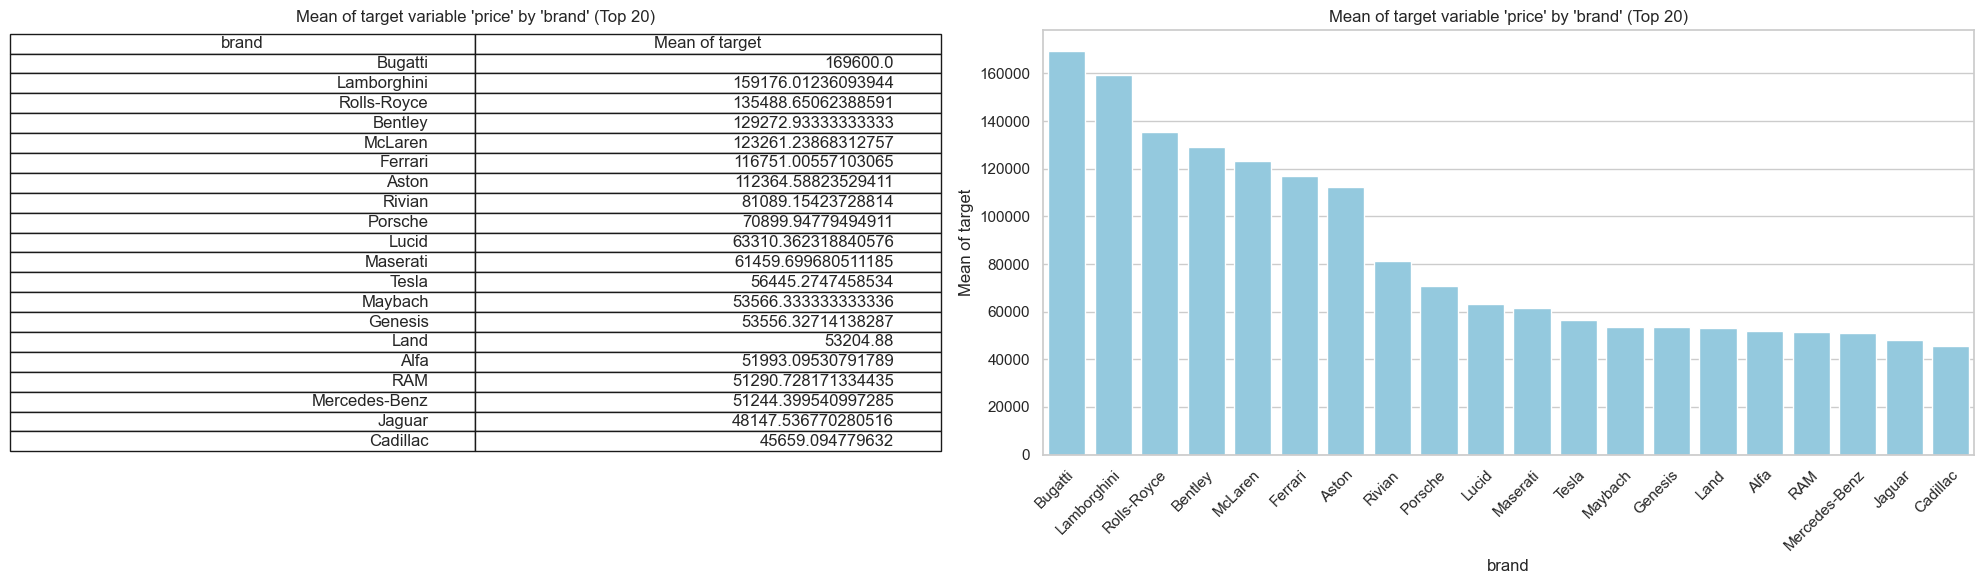

Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_dist_brand_20241206.png


--- EDA for model ---
Column 'model' has too many unique values (1897). Consider binning or filtering.
Unique values and counts for model (Top 20):
Missing values for model: 0
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/unique_values_count_model_20241206.png


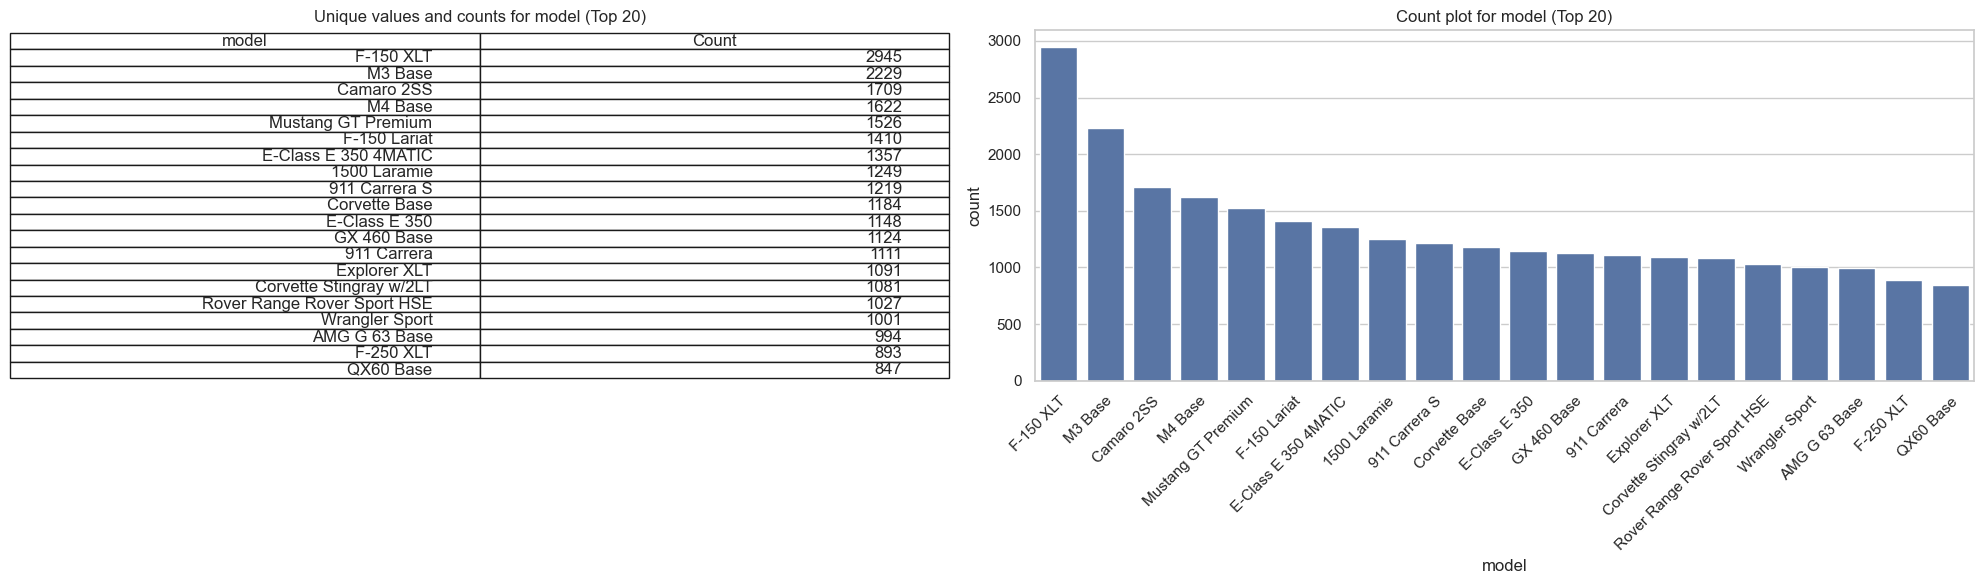

Analyzing relationship between 'model' and 'price'...
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_mean_model_20241206.png


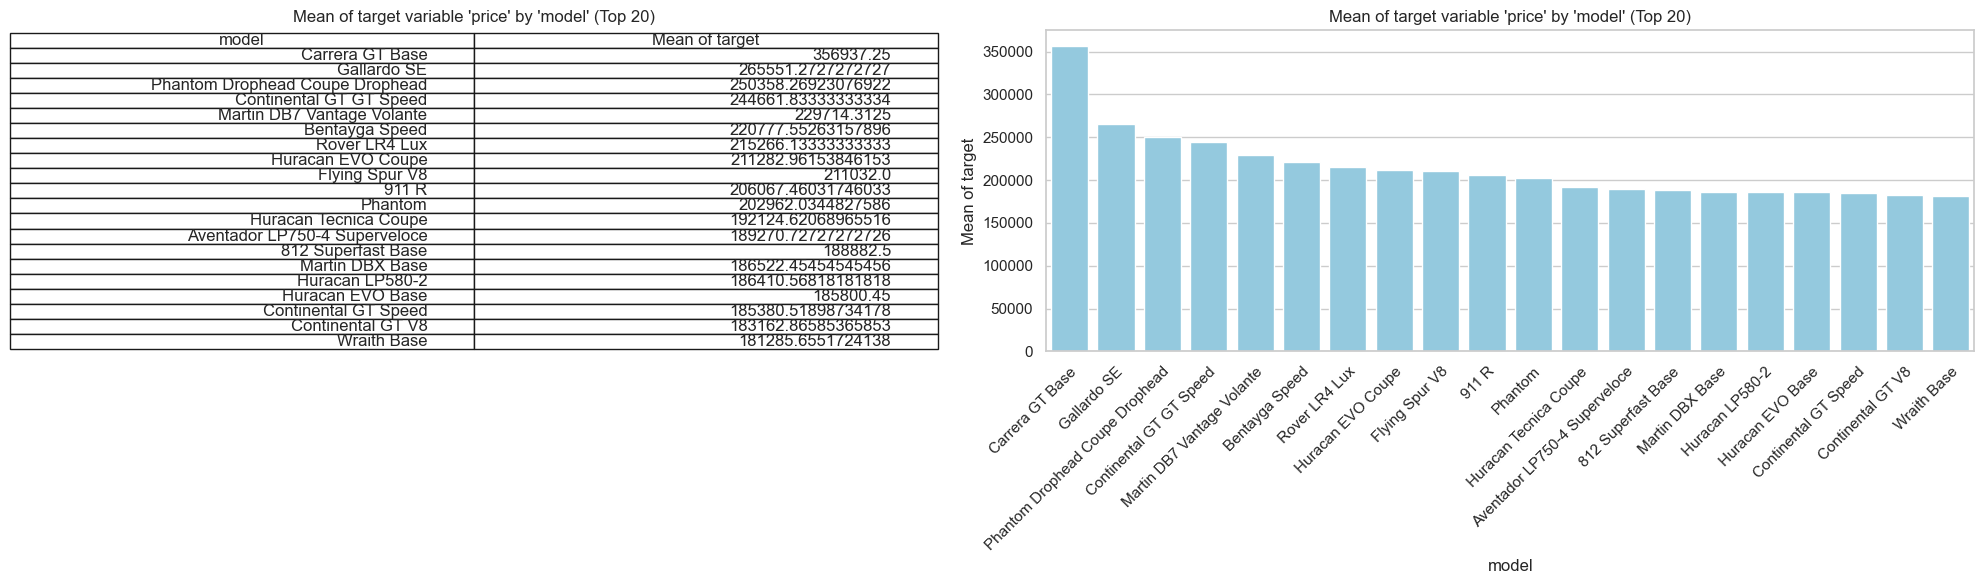

Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_dist_model_20241206.png


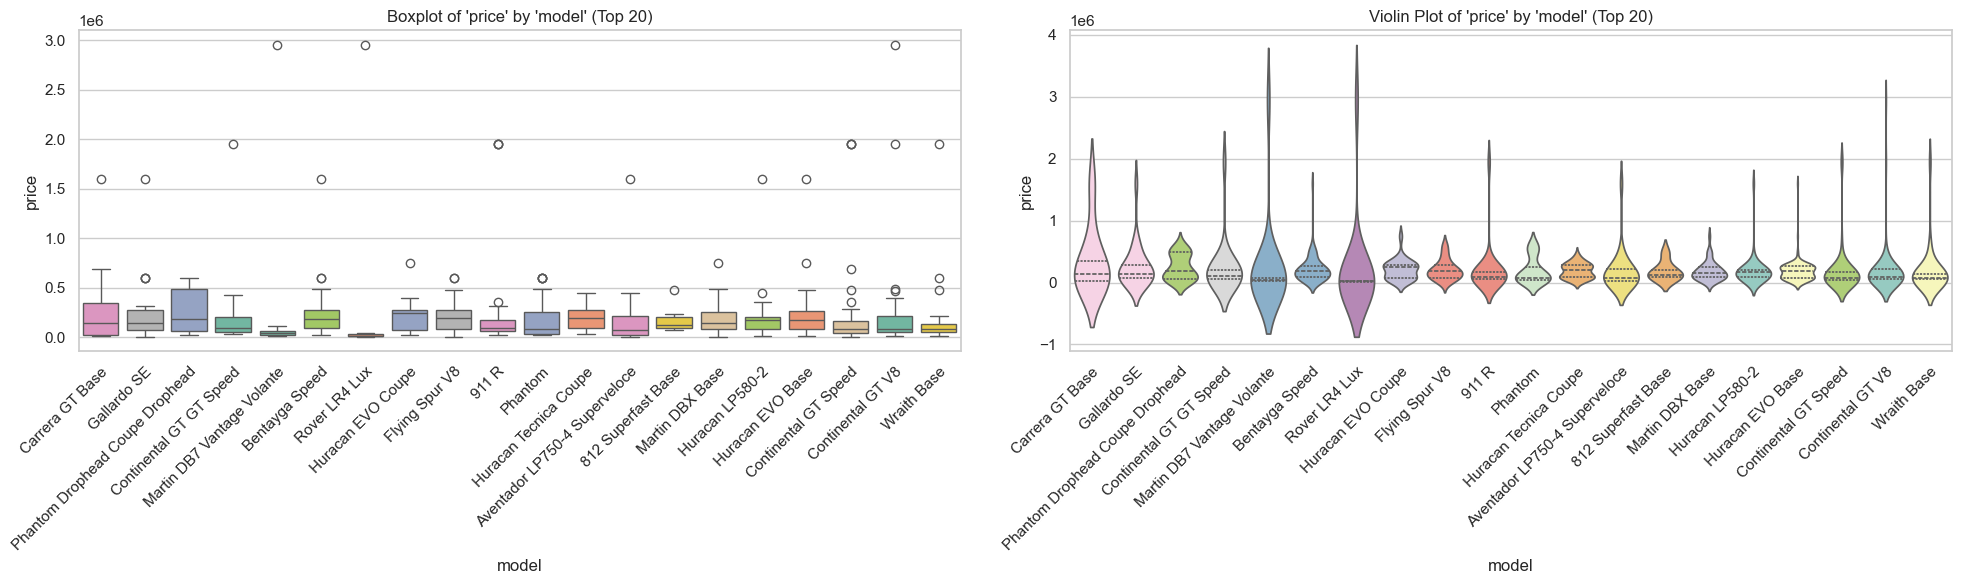

--- EDA for fuel_type ---
Unique values and counts for fuel_type (Top 20):
Missing values for fuel_type: 5083
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/unique_values_count_fuel_type_20241206.png


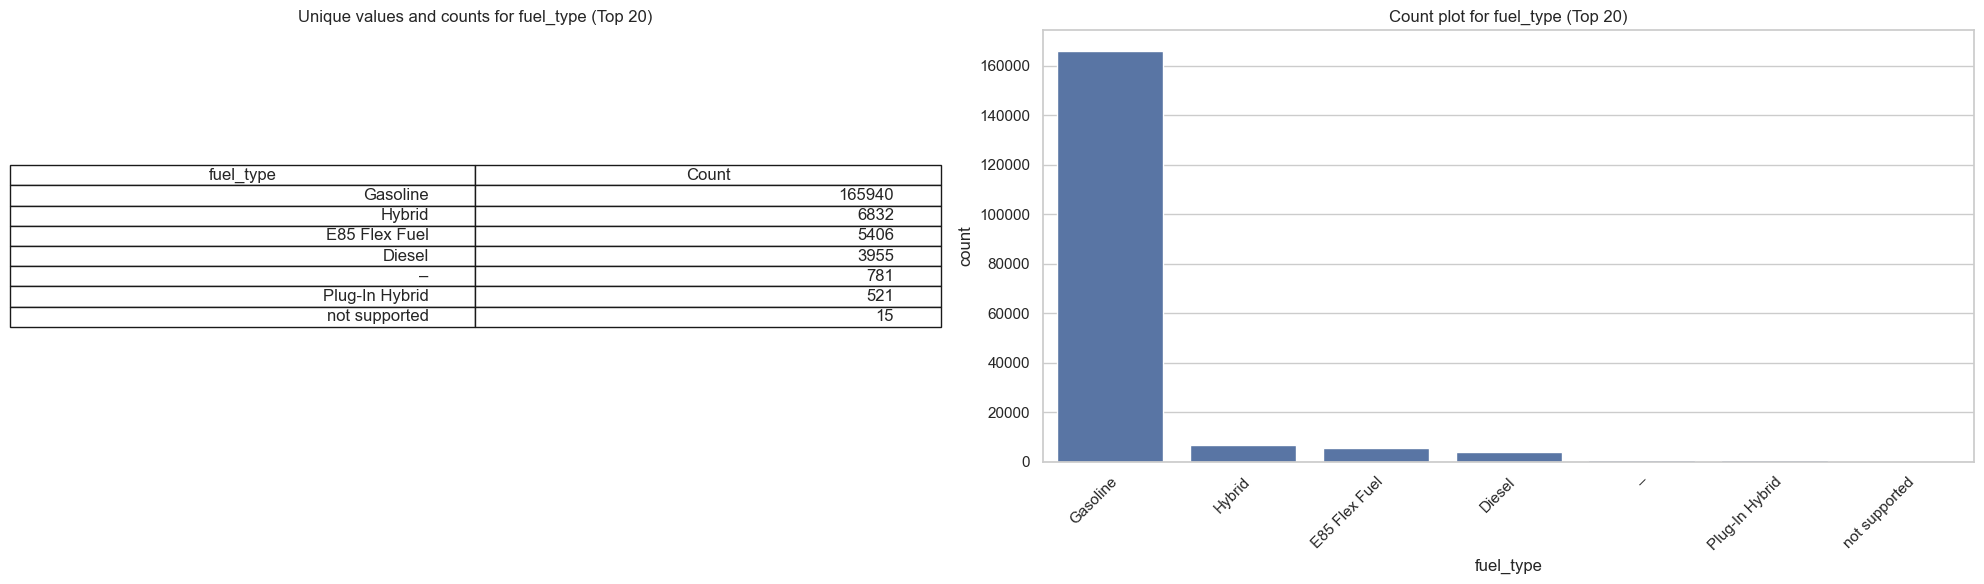

Analyzing relationship between 'fuel_type' and 'price'...
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_mean_fuel_type_20241206.png


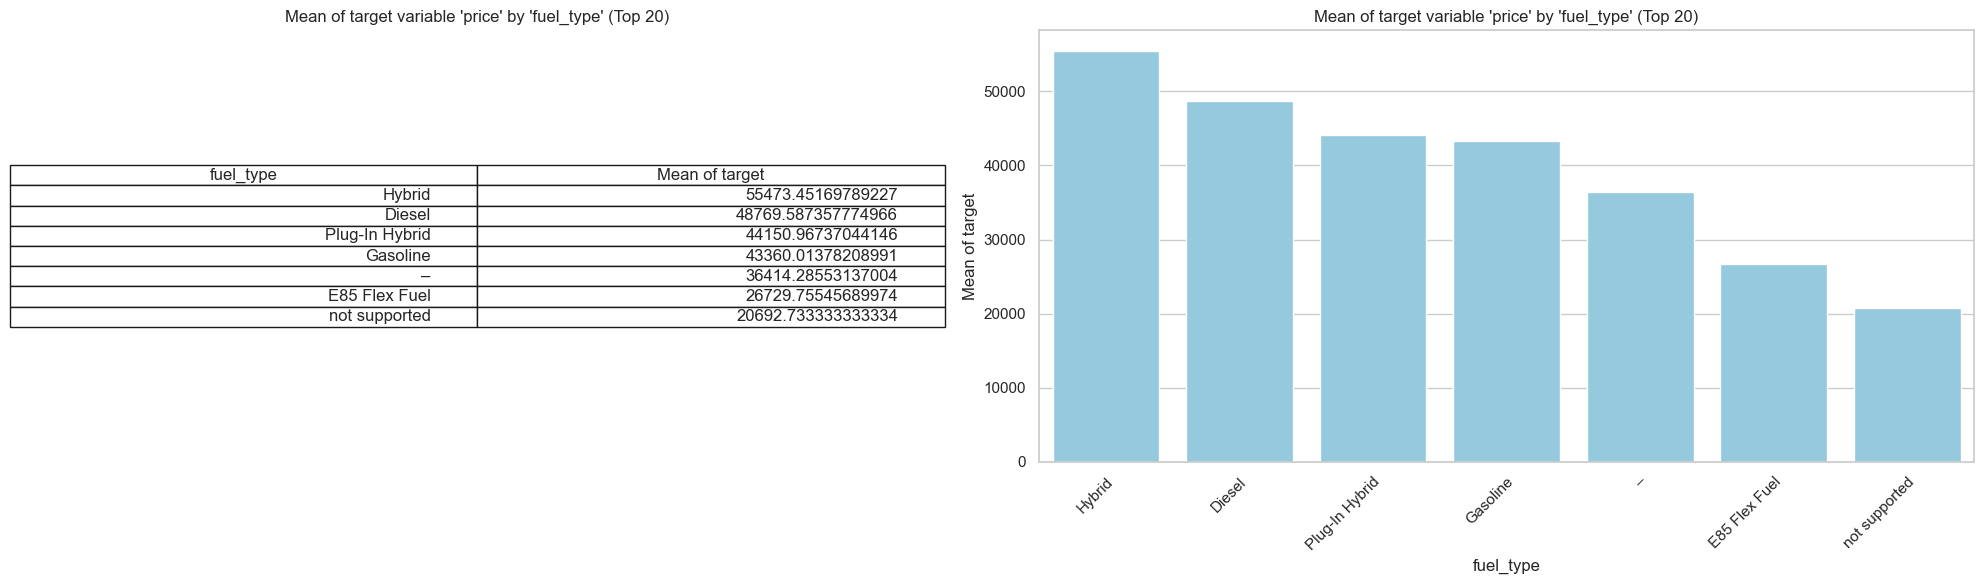

Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_dist_fuel_type_20241206.png


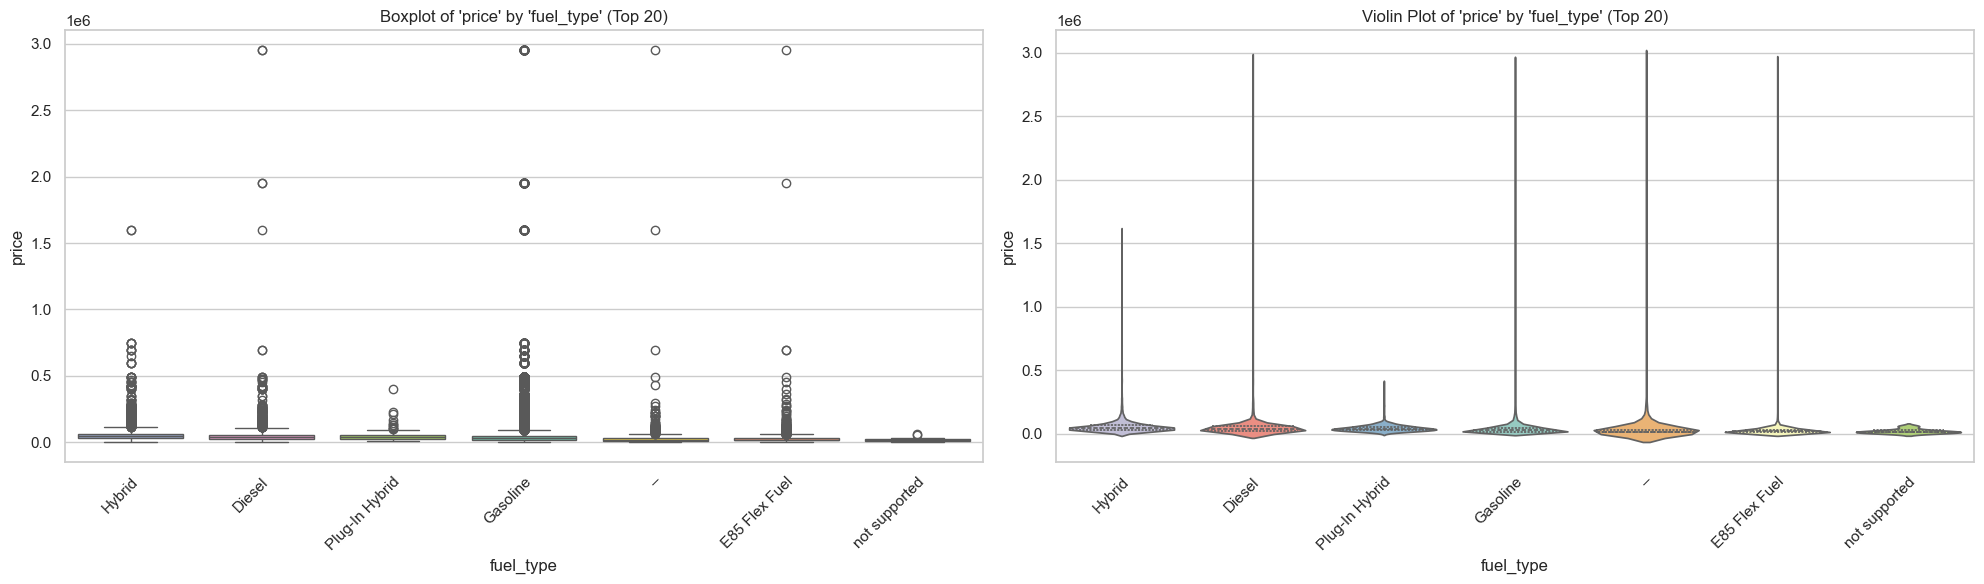

--- EDA for engine ---
Column 'engine' has too many unique values (1117). Consider binning or filtering.
Unique values and counts for engine (Top 20):
Missing values for engine: 0
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/unique_values_count_engine_20241206.png


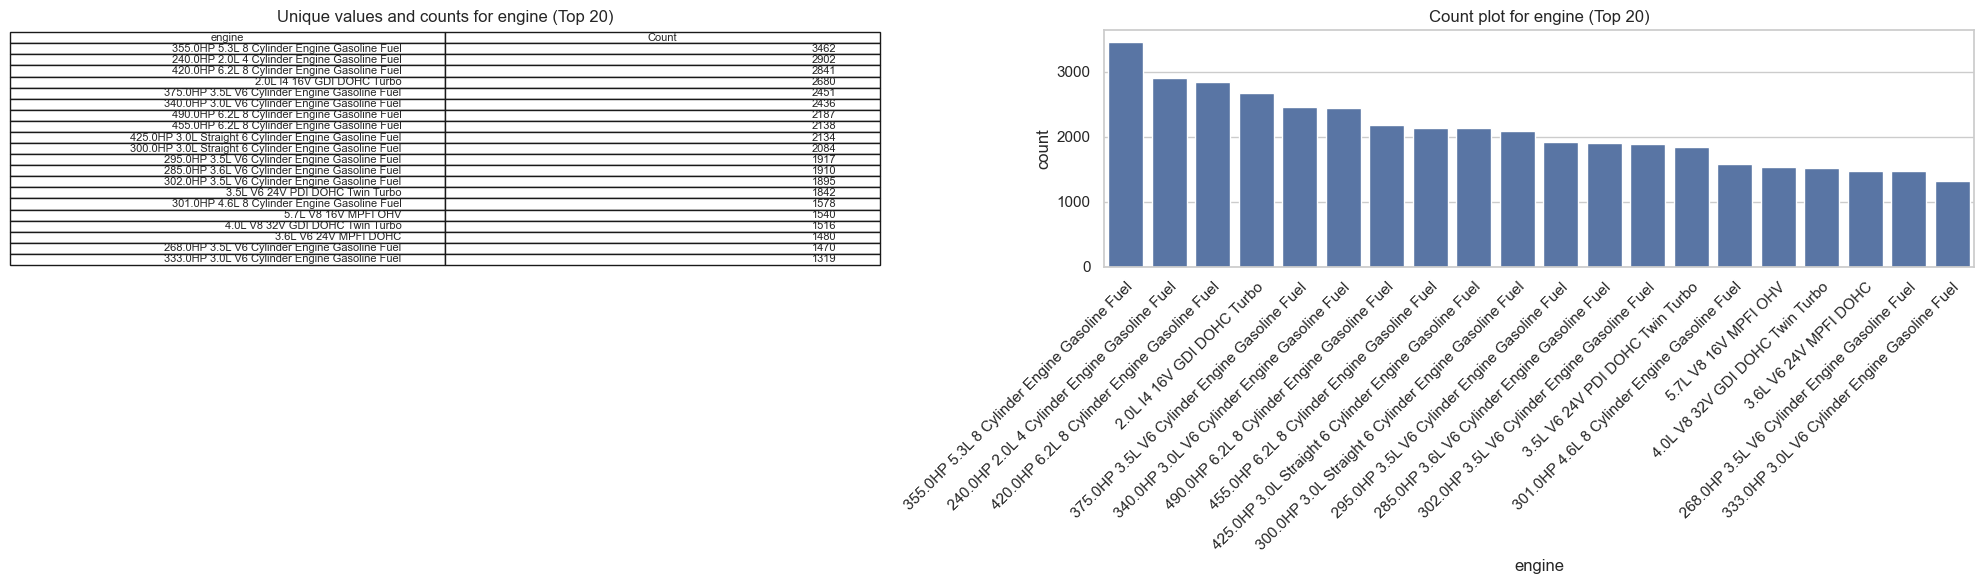

Analyzing relationship between 'engine' and 'price'...
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_mean_engine_20241206.png


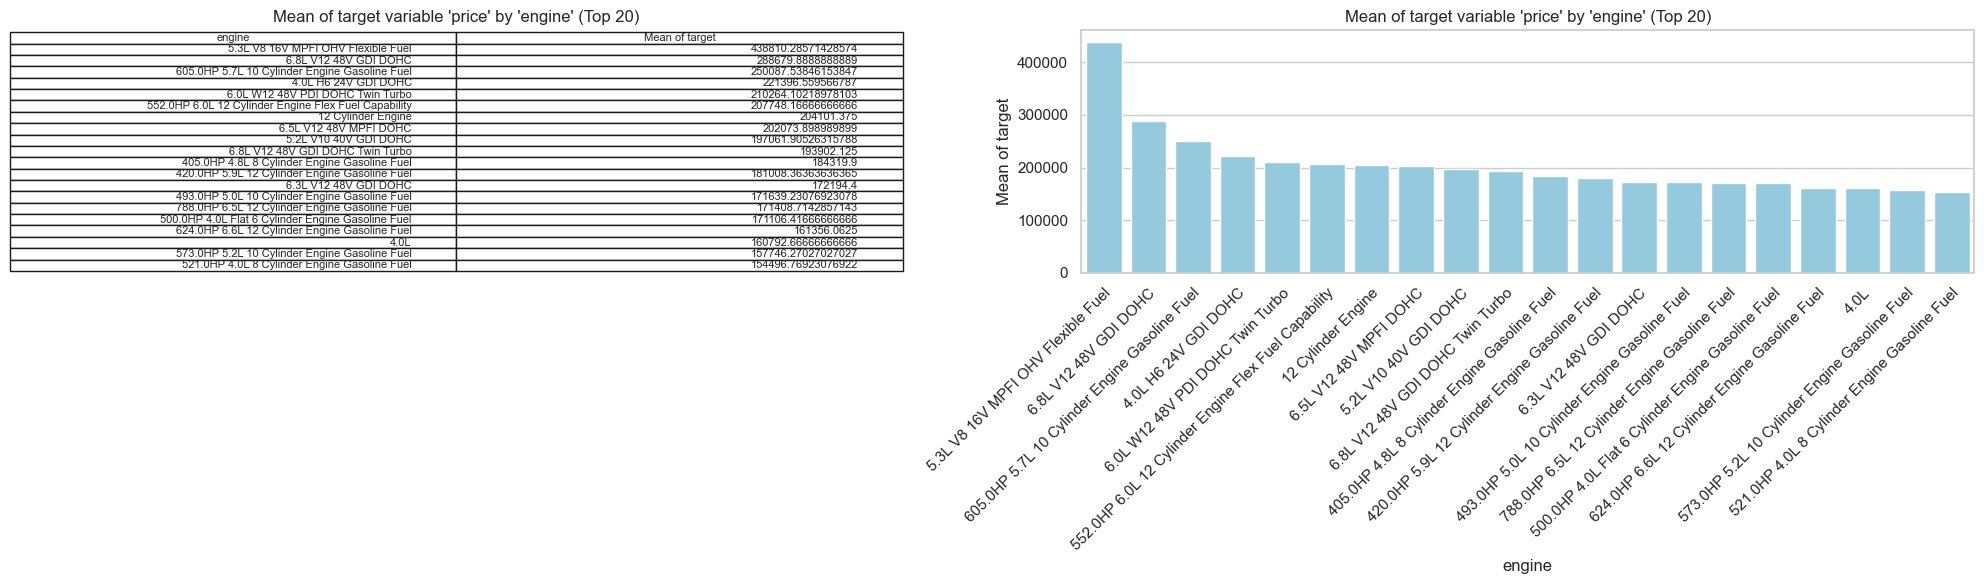

Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_dist_engine_20241206.png


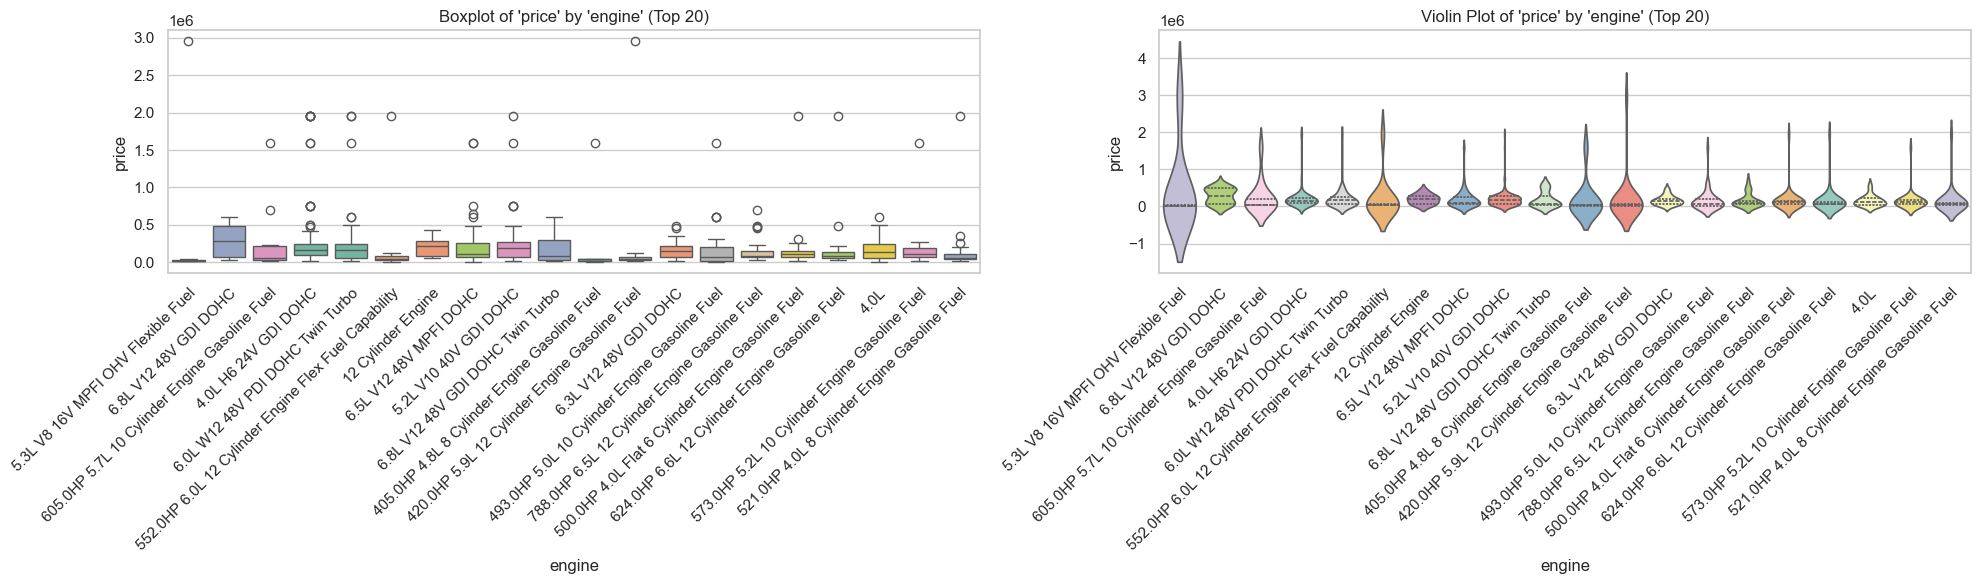

--- EDA for transmission ---
Column 'transmission' has too many unique values (52). Consider binning or filtering.
Unique values and counts for transmission (Top 20):
Missing values for transmission: 0
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/unique_values_count_transmission_20241206.png


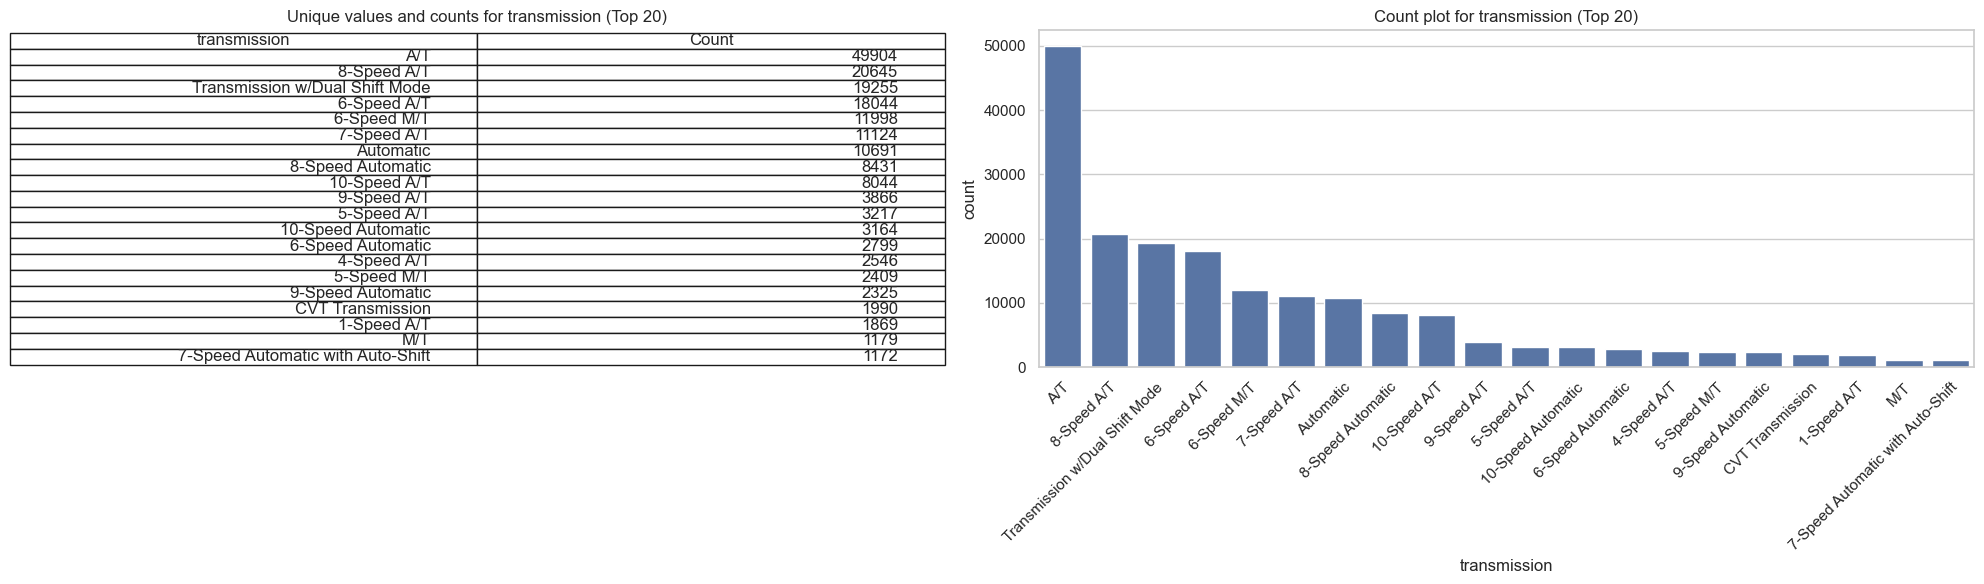

Analyzing relationship between 'transmission' and 'price'...
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_mean_transmission_20241206.png


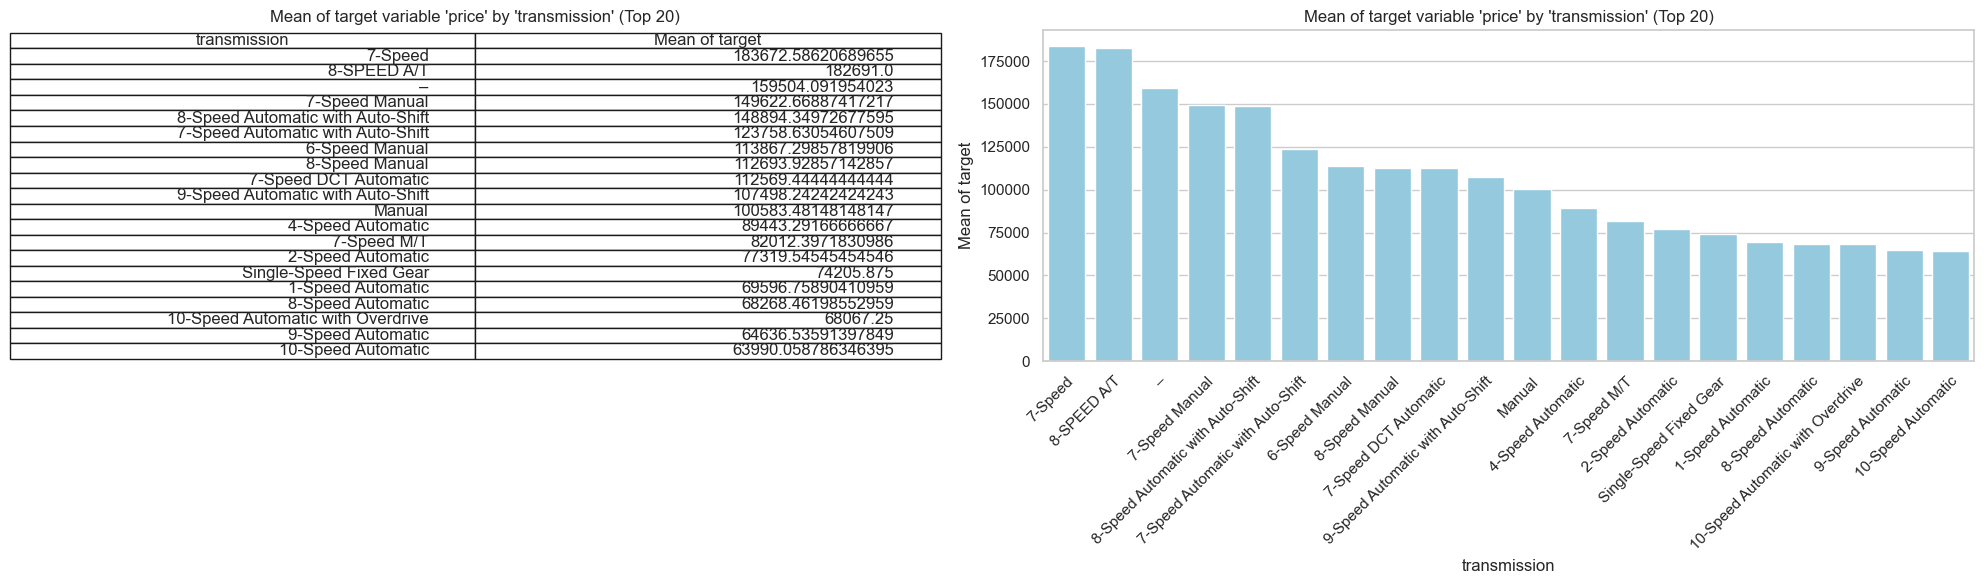

Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_dist_transmission_20241206.png


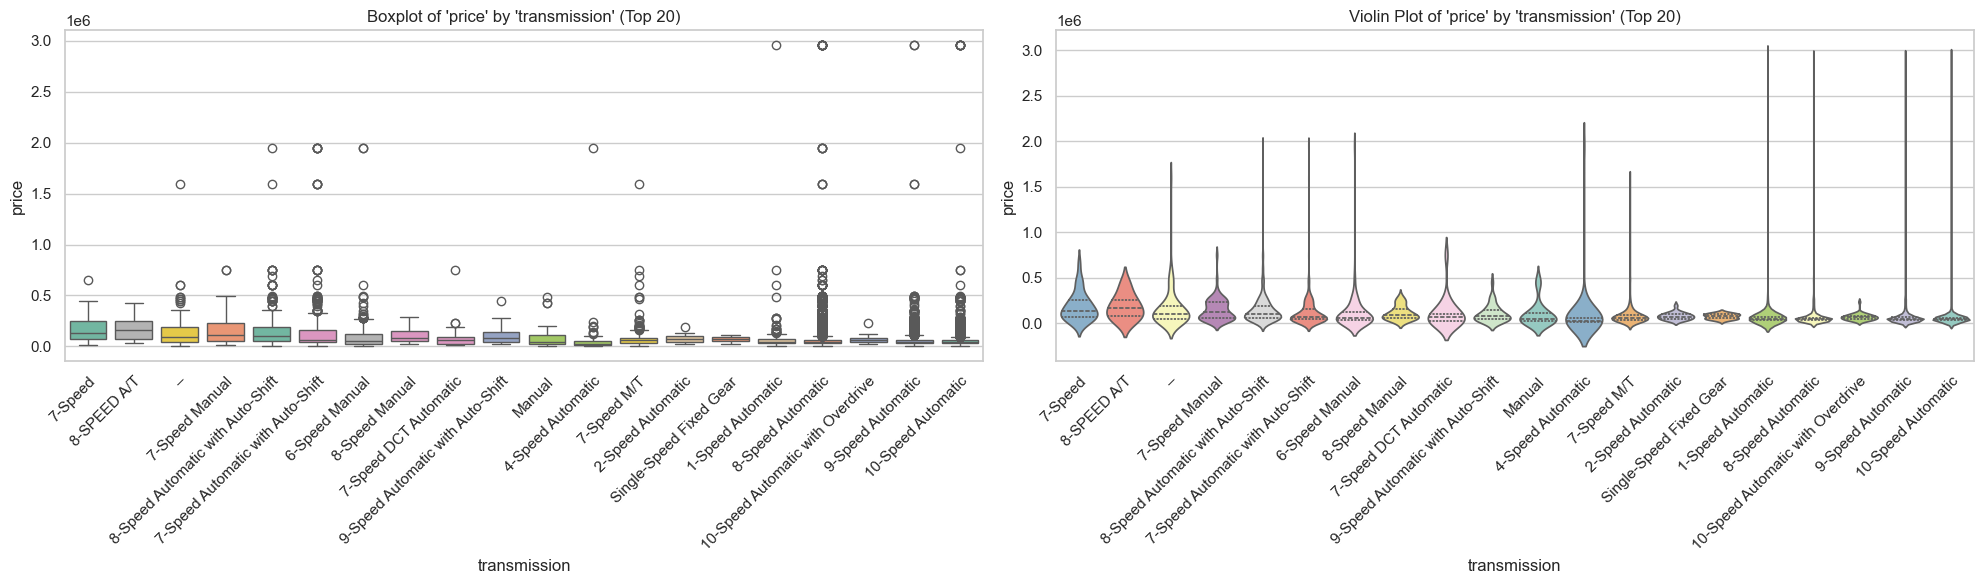

--- EDA for ext_col ---
Column 'ext_col' has too many unique values (319). Consider binning or filtering.
Unique values and counts for ext_col (Top 20):
Missing values for ext_col: 0
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/unique_values_count_ext_col_20241206.png


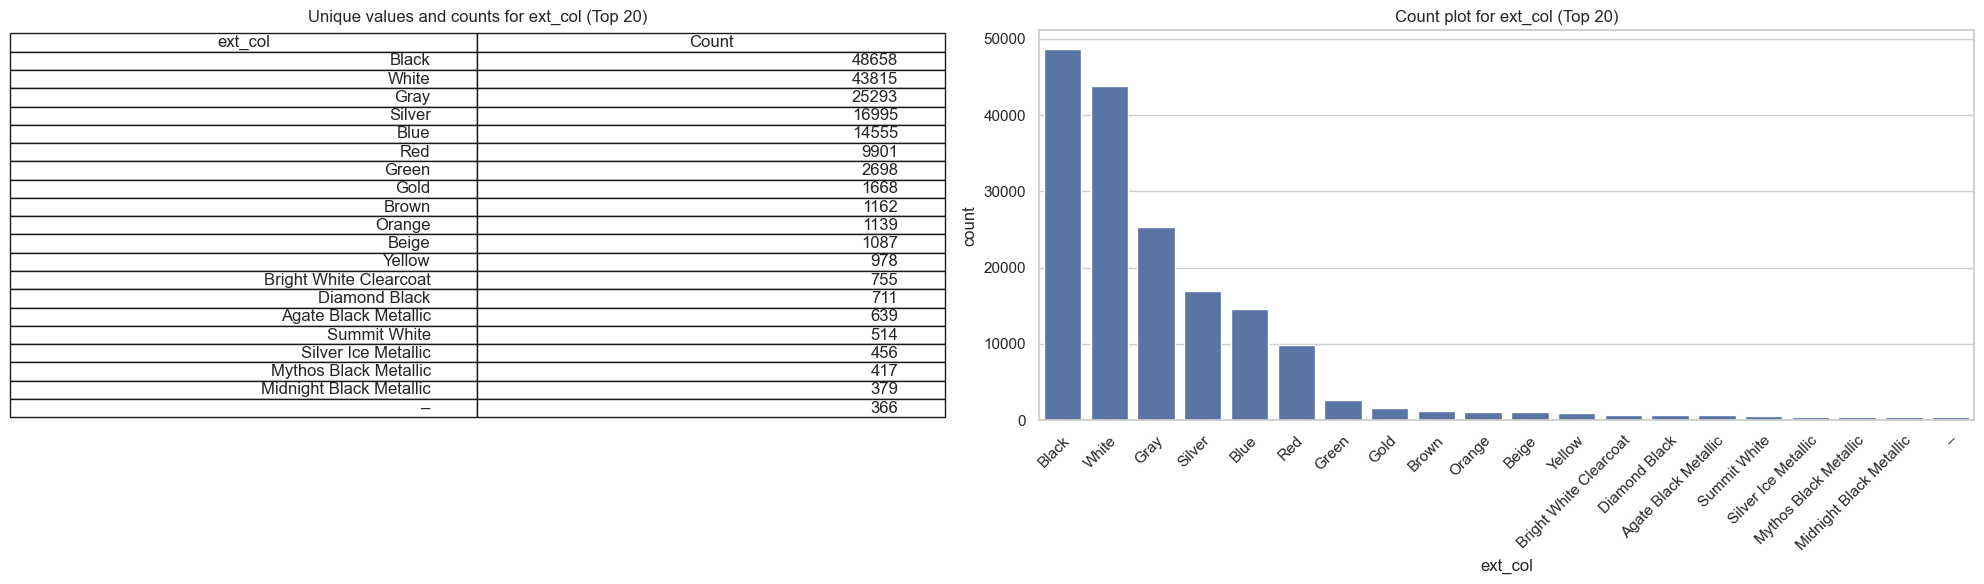

Analyzing relationship between 'ext_col' and 'price'...
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_mean_ext_col_20241206.png


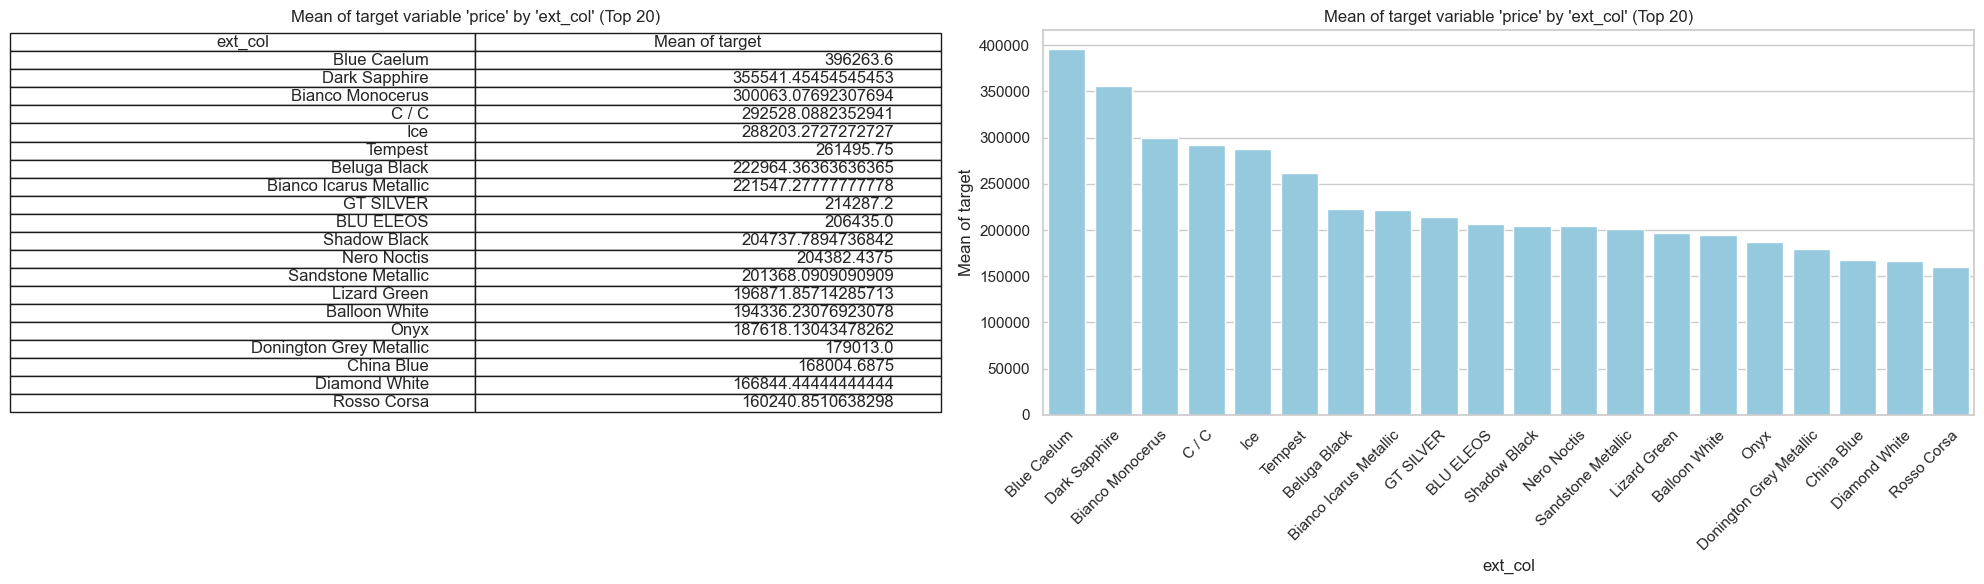

Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_dist_ext_col_20241206.png


--- EDA for int_col ---
Column 'int_col' has too many unique values (156). Consider binning or filtering.
Unique values and counts for int_col (Top 20):
Missing values for int_col: 0
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/unique_values_count_int_col_20241206.png


Analyzing relationship between 'int_col' and 'price'...
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_mean_int_col_20241206.png


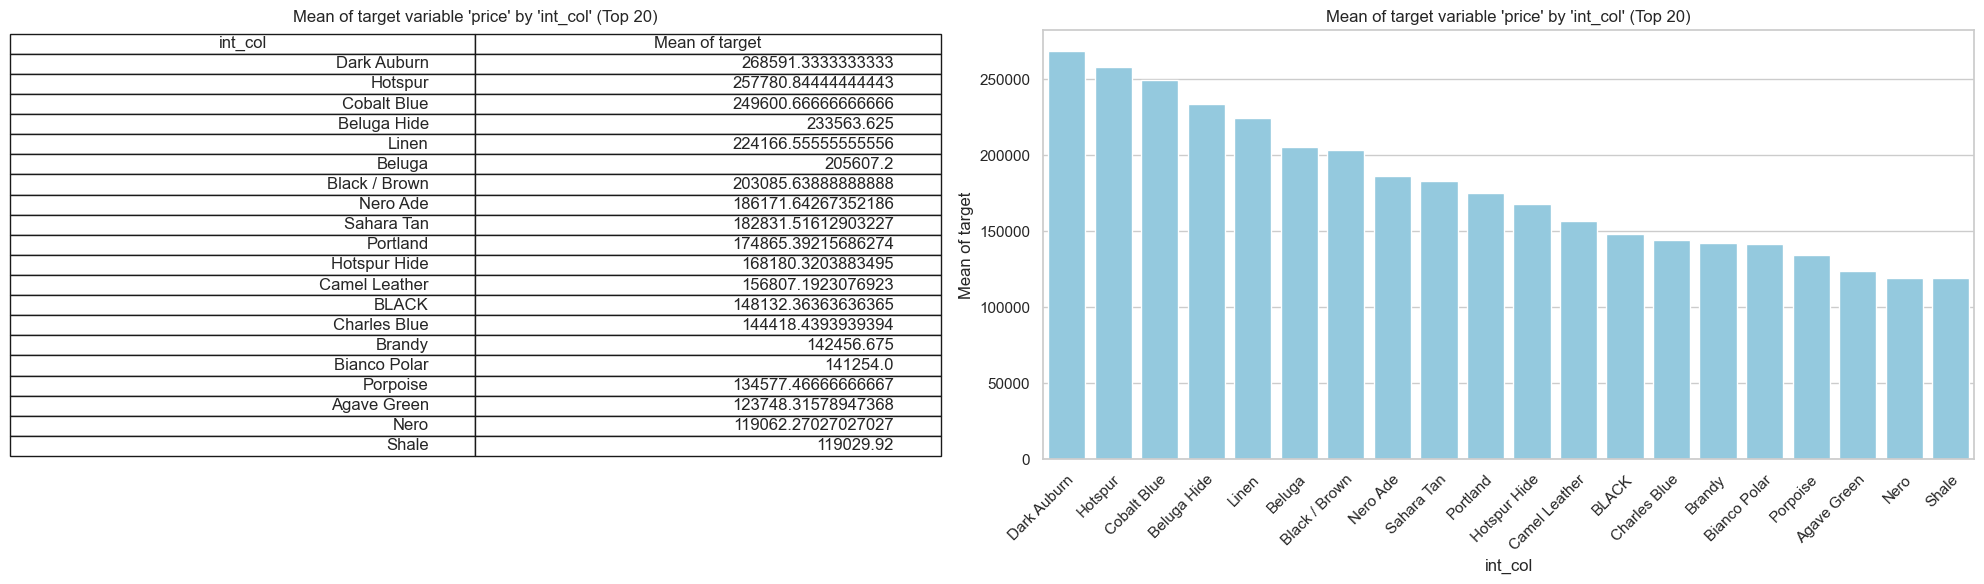

Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_dist_int_col_20241206.png


--- EDA for accident ---
Unique values and counts for accident (Top 20):
Missing values for accident: 2452
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/unique_values_count_accident_20241206.png


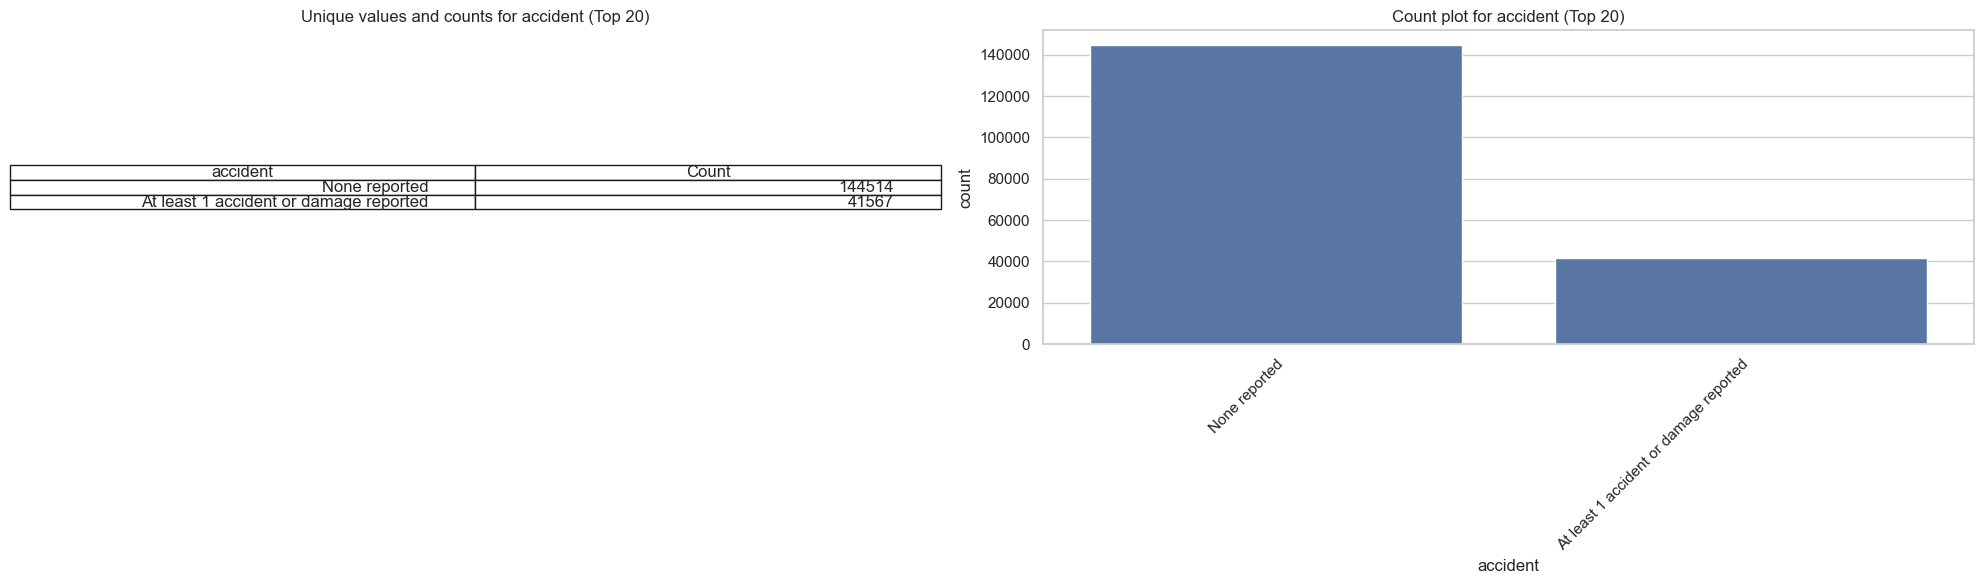

Analyzing relationship between 'accident' and 'price'...
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_mean_accident_20241206.png


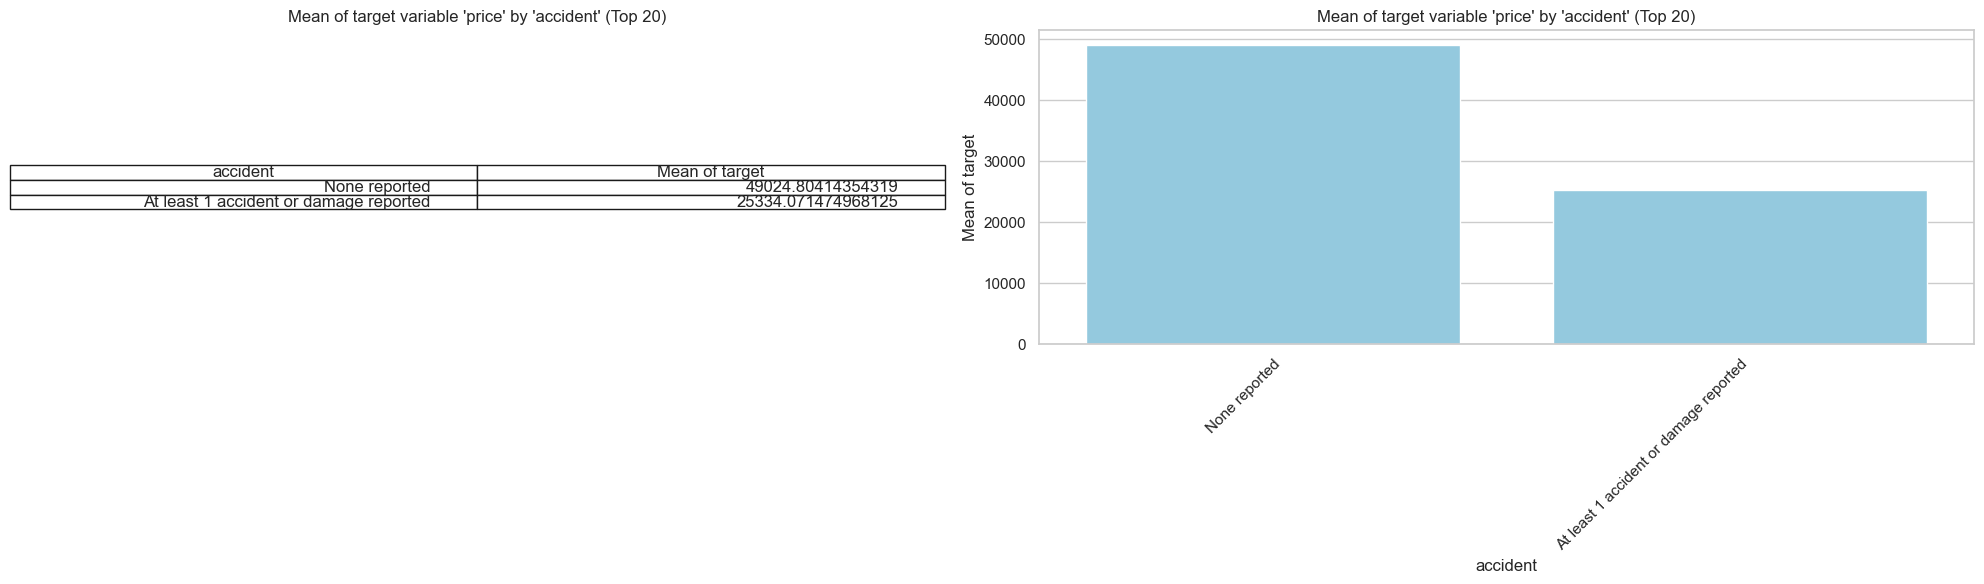

Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_dist_accident_20241206.png


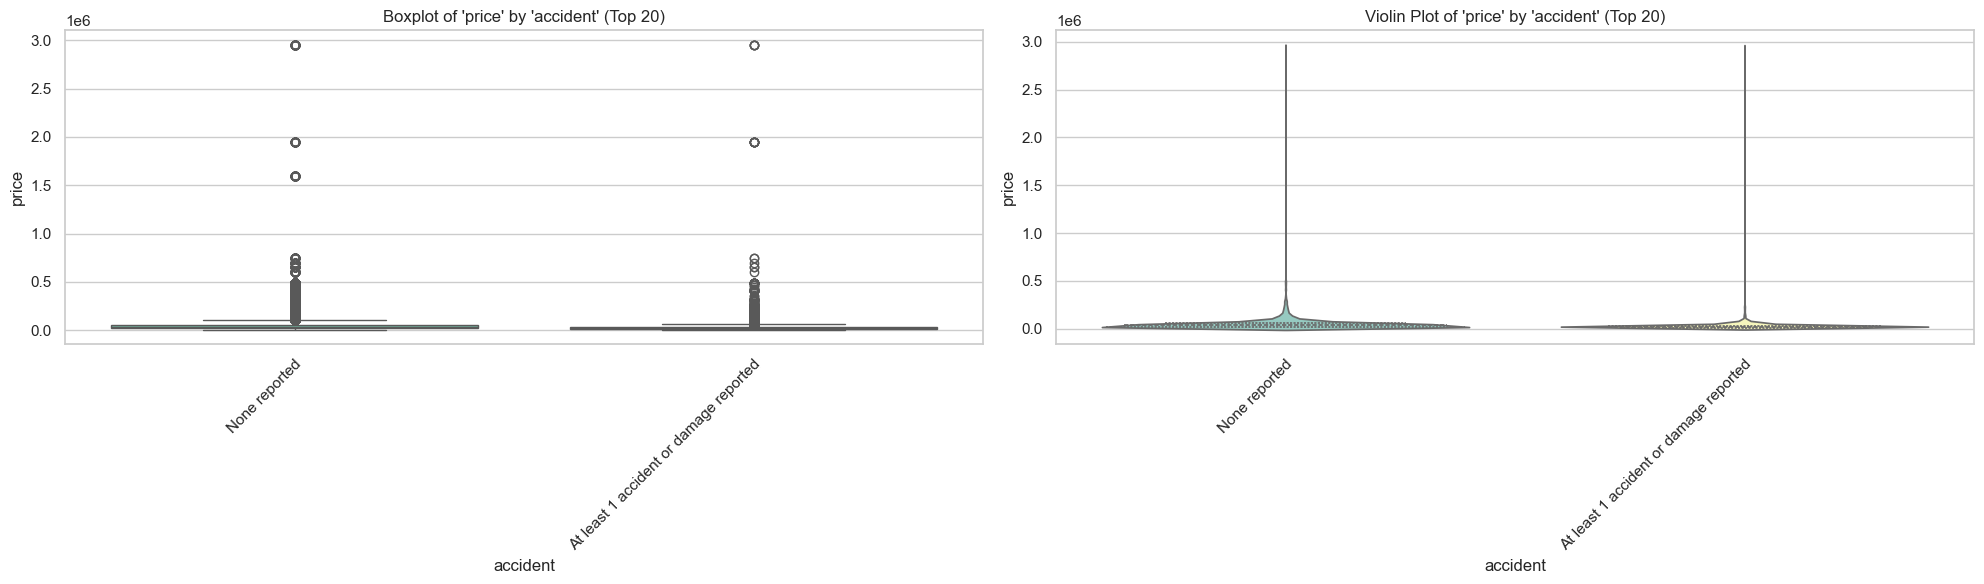

--- EDA for clean_title ---
Unique values and counts for clean_title (Top 20):
Missing values for clean_title: 21419
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/unique_values_count_clean_title_20241206.png


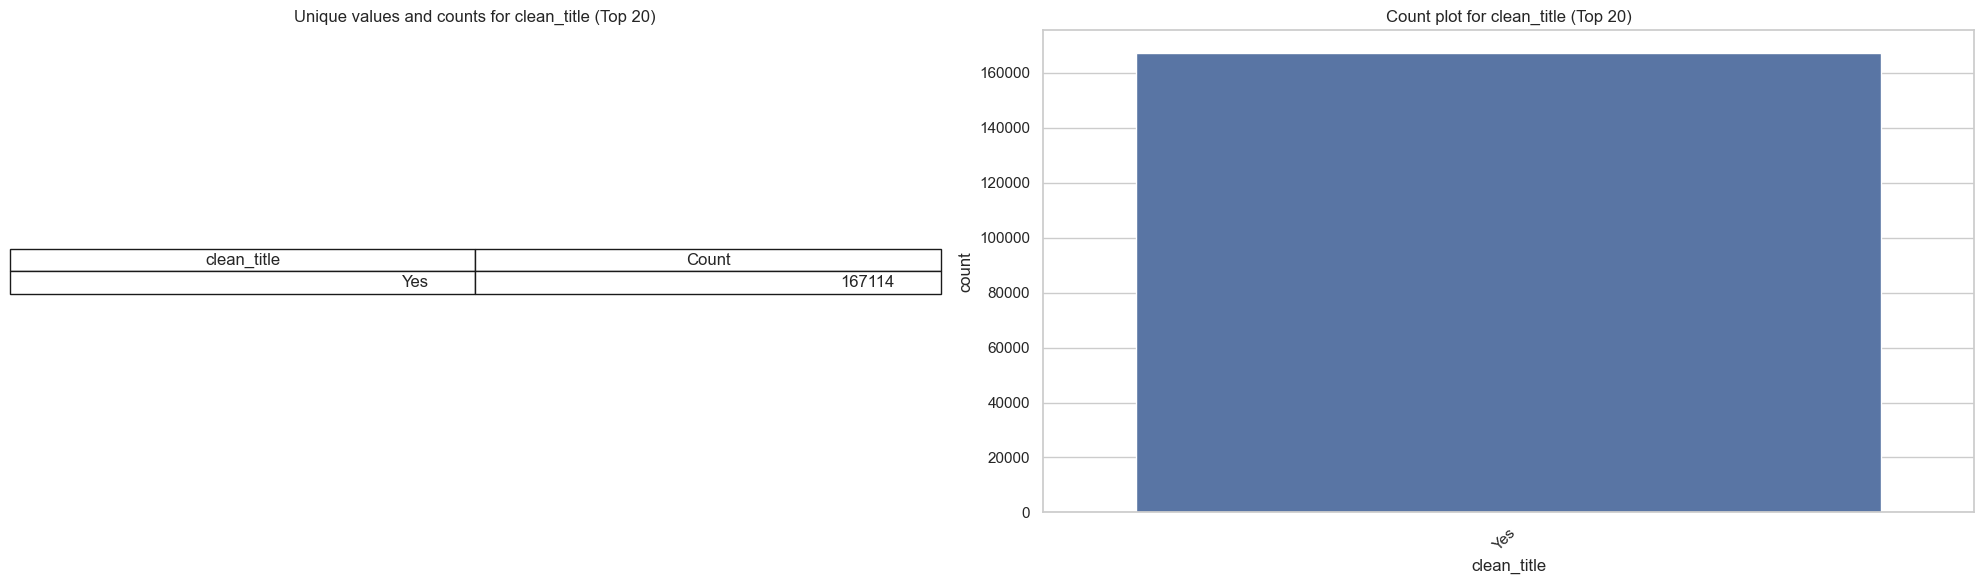

Analyzing relationship between 'clean_title' and 'price'...
Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_mean_clean_title_20241206.png


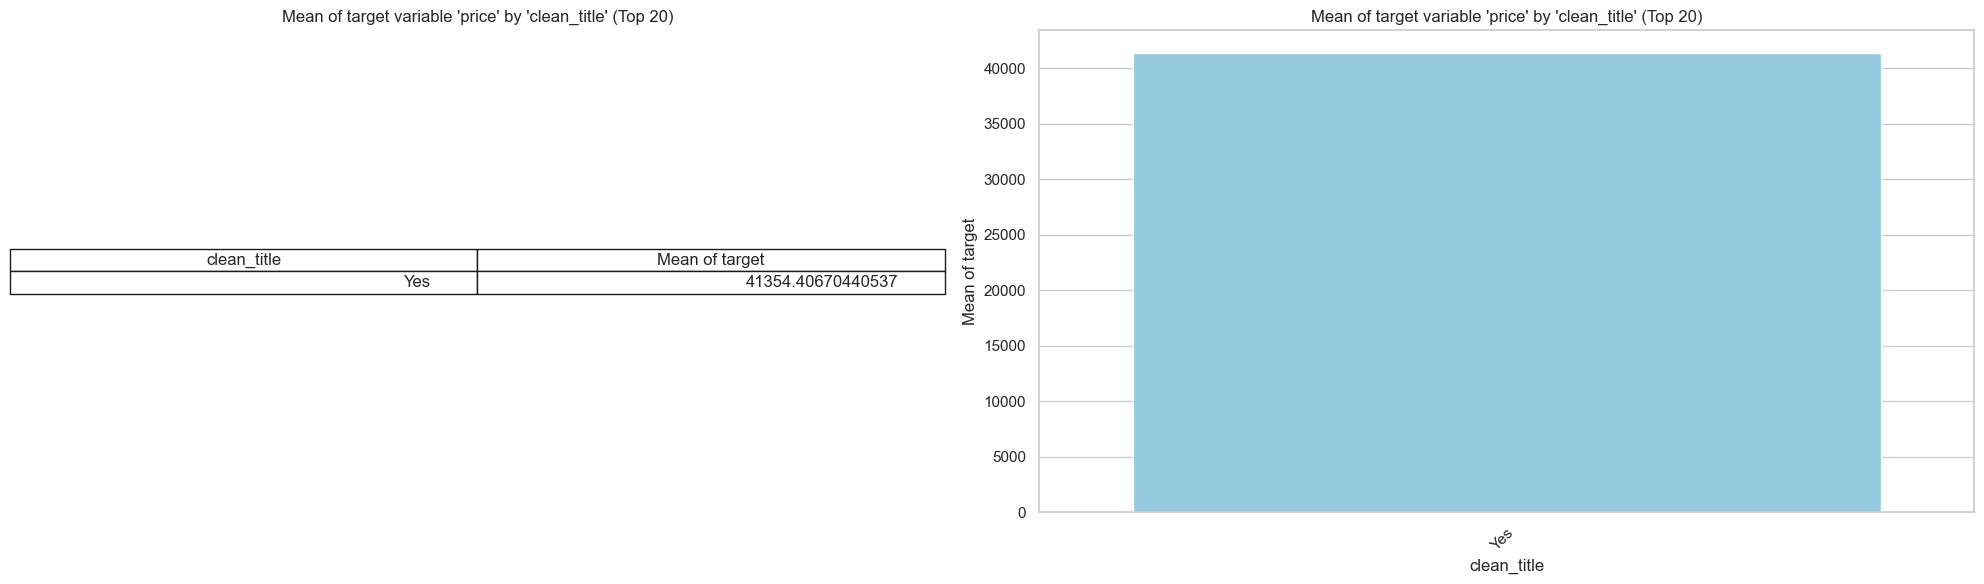

Saved: /Users/daeyoungkim/MSU/Fall_2024/STT_810/project/eda/target_dist_clean_title_20241206.png


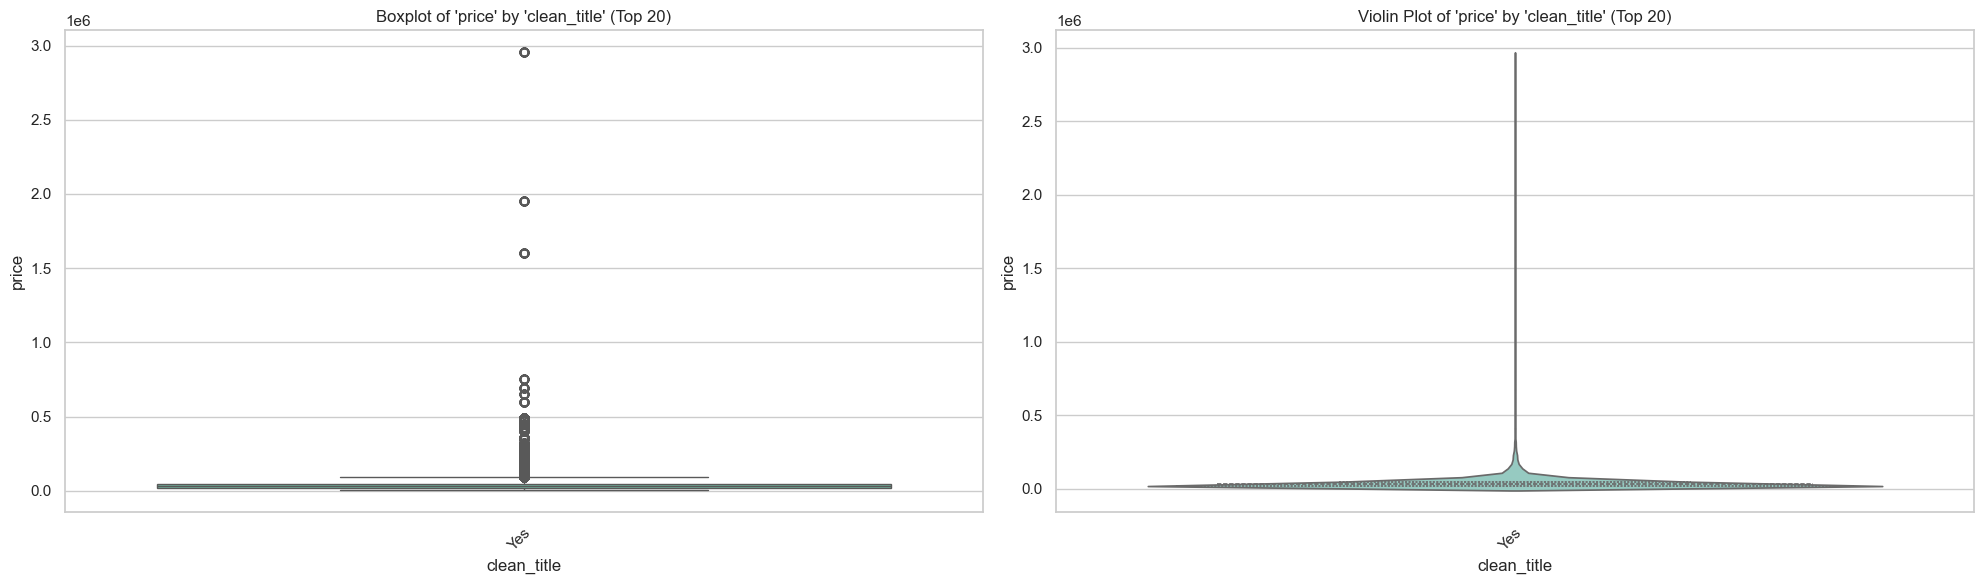

In [152]:
# EDA on categorical variables

def eda_categorical(df, categorical_cols, target):
    for col in categorical_cols:
        print('=' * 50)
        print(f"--- EDA for {col} ---")

        # Count the number of unique values in the column
        unique_count = df[col].nunique()
        if unique_count > 30:
            print(f"Column '{col}' has too many unique values ({unique_count}). Consider binning or filtering.")
        
        # Print unique values and counts (only the top 20)
        unique_values_counts = df[col].value_counts().head(20)
        print(f"Unique values and counts for {col} (Top 20):")
        # print(unique_values_counts)
        
        # Print missing values count
        missing_count = df[col].isnull().sum()
        print(f"Missing values for {col}: {missing_count}")
        
        # Visualize unique values and their counts
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        
        # 1) Visualize unique values and counts as a table
        table = axes[0].table(
            cellText=unique_values_counts.reset_index().values,
            colLabels=[col, 'Count'], 
            loc='center'
        )
        table.auto_set_font_size(True) # auto font size control
        table.scale(1.0, 1.3) # width scale, height scale
        axes[0].axis('tight')
        axes[0].axis('off')
        axes[0].set_title(f"Unique values and counts for {col} (Top 20)")

        # 2) Visualize counts using a bar plot
        sns.countplot(
            data=df, x=col, 
            order=df[col].value_counts().index[:20], ax=axes[1]
        )
        axes[1].set_title(f"Count plot for {col} (Top 20)")
        plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        plt.tight_layout()
        # save_my_figure(to_save=fig, filename=f'unique_values_count_{col}', extra_path='eda', add_datetime=True)        
        plt.show()

        # Calculate target variable mean and visualize
        if target in df.columns:
            target_mean = df.groupby(col)[target].mean().nlargest(20)

            print(f"Analyzing relationship between '{col}' and '{target}'...")

            # Visualize the target variable mean by category
            fig, axes = plt.subplots(1, 2, figsize=(20, 6))
            
            # 1) Visualize the mean as a table
            table = axes[0].table(
                cellText=target_mean.reset_index().values,
                colLabels=[col, 'Mean of target'], 
                loc='center'
            )
            table.auto_set_font_size(True) # auto font size control
            table.scale(1.0, 1.3) # width scale, height scale
            axes[0].axis('tight')
            axes[0].axis('off')
            axes[0].set_title(f"Mean of target variable '{target}' by '{col}' (Top 20)")

            # 2) Visualize the mean as a bar plot
            sns.barplot(data=target_mean, color='skyblue', ax=axes[1])
            axes[1].set_title(f"Mean of target variable '{target}' by '{col}' (Top 20)")
            axes[1].set_ylabel('Mean of target')
            plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

            plt.tight_layout()
            # save_my_figure(to_save=fig, filename=f'target_mean_{col}', extra_path='eda', add_datetime=True)     
            plt.show()
            
            # Visualize target variable distribution by category
            fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        
            # 1) Boxplot
            top_categories = target_mean.index.tolist()
            cond = df[col].isin(top_categories)
            sns.boxplot(x=col, y=target, data=df[cond], ax=axes[0], order=top_categories, hue=col, palette="Set2")
            axes[0].set_title(f"Boxplot of '{target}' by '{col}' (Top 20)")
            plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
            # 2) Violin plot
            sns.violinplot(x=col, y=target, data=df[cond], ax=axes[1], order=top_categories, hue=col, palette="Set3", inner="quartile")
            axes[1].set_title(f"Violin Plot of '{target}' by '{col}' (Top 20)")
            plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            
            plt.tight_layout()
            # save_my_figure(to_save=fig, filename=f'target_dist_{col}', extra_path='eda', add_datetime=True)
            plt.show()

# Select columns that are categorical (of type 'object' or 'category') from the train dataset
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
# Run the EDA on categorical columns
eda_categorical(train, categorical_cols, 'price')

# Train/Test Split

In [86]:
# Set X and y
X = train.drop(columns=['price']).copy()
y = train['price'].copy()

# Train/test split
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)
print(f"Train Shape: {X_train.shape}, Validation Shape: {X_test.shape}")

Train Shape: (150826, 11), Validation Shape: (37707, 11)


# Feature Engineering

- data cleaning and preprocessing
- transformation

## Handling Missing values

In [87]:
# Function to handle missing values
def impute_rf(train, test, column):
    X_train = train.copy()
    X_test = test.copy()
    
    # Split the data into rows with missing and non-missing values in the target column
    train_data = X_train[X_train[column].notnull()].copy()
    missing_train_data = X_train[X_train[column].isnull()].copy()
    
    # List all features excluding the target column
    feature_columns = [col for col in X_train.columns if col != column]
    
    # Create the pipeline for imputing missing values
    # Split features into categorical and numeric types
    categorical_features = X_train[feature_columns].select_dtypes(include=['object', 'category']).columns
    numeric_features = X_train[feature_columns].select_dtypes(include=['int64', 'float64']).columns
    
    # Create a preprocessor that applies median imputation to numeric features and one-hot encoding to categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Apply label encoding to the target column
    le = LabelEncoder()
    train_data[column] = le.fit_transform(train_data[column].astype(str))
    
    # Create a pipeline that combines the preprocessing and the random forest classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=777))
    ])
    
    # Prepare features and target variable for training
    X_train_features = train_data[feature_columns]
    y_train = train_data[column]
    
    # Train the model using the pipeline
    pipeline.fit(X_train_features, y_train)
    
    # Impute missing values in the training data (train_df)
    if not missing_train_data.empty: 
        X_missing_train_features = missing_train_data[feature_columns]# Features for rows with missing values in the target column
        preds_missing_train = pipeline.predict(X_missing_train_features) # Predict the missing values
        X_train.loc[X_train[column].isnull(), column] = le.inverse_transform(preds_missing_train) # Replace missing values with predicted values
    
    # Impute missing values in the test data (test_df)
    X_missing_test = X_test[X_test[column].isnull()] # Filter only the rows with missing values in the target column
    if not X_missing_test.empty:
        X_missing_test_features = X_missing_test.drop(columns=[column]) # Drop the target column to predict the missing values
        preds_missing_test = pipeline.predict(X_missing_test_features) # Predict the missing values
        X_test.loc[X_test[column].isnull(), column] = le.inverse_transform(preds_missing_test) # Replace missing values in test data
    # Return the modified training and test data, and the trained pipeline
    return X_train, X_test, pipeline

# Impute missing values in the 'fuel_type' column using the Random Forest model
X_train, X_test, fuel_type_imputer = impute_rf(X_train, X_test, 'fuel_type')

# Impute missing values in the 'accident' column by filling them with 'Unknown'
X_train['accident'] = X_train['accident'].fillna('Unknown')
X_test['accident'] = X_test['accident'].fillna('Unknown')

# Impute missing values in the 'clean_title' column
# Map 'Yes' to 1, empty and None values to 0, and fill missing values with 0
X_train['clean_title'] = X_train['clean_title'].map({'Yes': 1, '': 0, None: 0}).fillna(0).fillna(0)
X_test['clean_title'] = X_test['clean_title'].map({'Yes': 1, '': 0, None: 0}).fillna(0).fillna(0)

# Print the number of missing values in each column of the training and test data
print(X_train.isna().sum())
print(X_test.isna().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64


## Feature Creation
- creating new features or modifying existing ones
- interaction features, binning, aggregations

In [88]:
# Features creation

def clean_data(data, to_impute=None):

    df = data.copy()

    # Create 'car_grade' column based on car brand categories
    df['car_grade'] = np.select(
        [
            # Economic brands
            df['brand'].str.lower().isin([
                'toyota', 'honda', 'chevrolet', 'ford', 'nissan', 'hyundai', 'kia', 'mazda',
                'subaru', 'volkswagen', 'mitsubishi', 'fiat', 'saturn', 'scion', 'suzuki',
                'chrysler', 'plymouth', 'smart'
            ]),
            # Luxury brands
            df['brand'].str.lower().isin([
                'tesla', 'bmw', 'mercedes-benz', 'audi', 'lexus', 'infiniti', 'acura',
                'cadillac', 'volvo', 'lincoln', 'genesis', 'buick', 'alfa', 'polestar', 'lucid'
            ]),
            # Sport/Luxury brands
            df['brand'].str.lower().isin([
                'porsche', 'ferrari', 'lamborghini', 'maserati', 'aston', 'mclaren',
                'bugatti', 'lotus', 'jaguar', 'bentley', 'rolls-royce', 'maybach',
                'karma', 'rivian'
            ]),
            # Off-road/Utility brands
            df['brand'].str.lower().isin([
                'jeep', 'ram', 'gmc', 'land', 'hummer'
            ])
        ],
        # Corresponding grade labels
        ['Economic', 'Luxury', 'Sport/Luxury', 'Off-road/Utility'],
        # Default label
        default='Other'
    )
    
    # Create a 'fuel_category' column based on 'fuel_type'
    df['fuel_category'] = np.select(
        [
            df['fuel_type'] == 'Gasoline',
            df['fuel_type'].isin(['Hybrid', 'Plug-In Hybrid']),
            df['fuel_type'] == 'Diesel',
            df['fuel_type'] == 'E85 Flex Fuel',
            df['fuel_type'].isin(['not supported', '-', ''])
        ],
        ['Gasoline', 'Hybrid', 'Diesel', 'Flex Fuel', 'Other'], # Unknown -> Other
        default='Other'
    )
    
    # Create 'transmission_category' column based on transmission type
    df['transmission_category'] = np.select(
        [
            df['transmission'].str.contains('A/T|Automatic', case=False, na=False),
            df['transmission'].str.contains('M/T|Manual', case=False, na=False),
            df['transmission'].str.contains('CVT', case=False, na=False),
            df['transmission'].str.contains('Auto-Shift|Dual Shift Mode', case=False, na=False)
        ],
        ['Automatic', 'Manual', 'CVT', 'Auto-Shift'],
        default='Other'
    )
    
    # Create 'accident_status' column based on accident history
    df['accident_status'] = np.select(
        [
            df['accident'] == 'None reported',
            df['accident'] == 'At least 1 accident or damage reported'
        ],
        [1, 0], # 1 for no accident, 0 for accident reported
        default=0
    )

    # Create 'engine_type' based on engine descriptions
    df['engine_type'] = np.select(
        [
            # Cylinder Configuration
            df['engine'].str.contains('V6', case=False, na=False),
            df['engine'].str.contains('V8', case=False, na=False),
            df['engine'].str.contains('I4|4 Cylinder', case=False, na=False),
            df['engine'].str.contains('Flat 6|H6', case=False, na=False),
            df['engine'].str.contains('V10', case=False, na=False),
            df['engine'].str.contains('V12', case=False, na=False),
            df['engine'].str.contains('I6|Straight 6', case=False, na=False),
            df['engine'].str.contains('I3|3 Cylinder', case=False, na=False),
            df['engine'].str.contains('H4', case=False, na=False),
            df['engine'].str.contains('V16|W16', case=False, na=False),
            df['engine'].str.contains('W12', case=False, na=False),
            
            # Fuel and Special Types
            df['engine'].str.contains('Electric', case=False, na=False),
            df['engine'].str.contains('Hybrid', case=False, na=False),
            df['engine'].str.contains('Rotary', case=False, na=False),
            df['engine'].str.contains('Flex Fuel', case=False, na=False)
        ],
        [
            'V6', 'V8', 'I4', 'Flat 6', 'V10', 'V12', 
            'Inline 6', 'Inline 3', 'Flat 4', 'V16/W16', 'W12', 
            'Electric', 'Hybrid', 'Rotary', 'Flex Fuel'
        ],
        default='Other'
    )

    # Engine group categorization
    df['engine_group'] = np.select(
        [
            # Main groups by cylinder type and fuel
            df['engine_type'].isin(['V6', 'I4', 'Inline 6']), # Common engines
            df['engine_type'].isin(['V8', 'Flat 6']), # High-performance engines
            df['engine_type'].isin(['V12', 'V10', 'V16/W16', 'W12']), # Exotic, rare engines
            df['engine_type'].isin(['Hybrid', 'Electric']), # Eco-friendly engines
            df['engine_type'].isin(['Flex Fuel', 'Rotary']) # Special engines
        ],
        [
            'Common',
            'High Performance',
            'Exotic',
            'Eco-Friendly',
            'Special'
        ],
        default='Other'
    )

    # Add engine technology features
    # a companion feature that captures engine technology details
    # captures advanced engine technologies that could significantly impact a car's valu
    df['engine_tech_features'] = np.select(
        [
            df['engine'].str.contains('Twin Turbo', case=False, na=False),
            df['engine'].str.contains('Supercharged', case=False, na=False),
            df['engine'].str.contains('PDI|GDI', case=False, na=False),
            df['engine'].str.contains('Turbo', case=False, na=False),
            df['engine'].str.contains('Hybrid', case=False, na=False)
        ],
        ['Twin Turbo', 'Supercharged', 'Direct Injection', 'Turbocharged', 'Hybrid Technology'],
        default='Standard'
    )
    
    # Simplify 'fuel_type' based on 'engine'
    df['fuel_type_simp'] = np.select(
        [
            # df['engine'].str.contains('Gas/Electric Hybrid', case=False, na=False),
            df['engine'].str.contains('Hybrid', case=False, na=False),
            df['engine'].str.contains('Electric/Gas', case=False, na=False),
            df['engine'].str.contains('Electric', case=False, na=False),
            df['engine'].str.contains('Gasoline', case=False, na=False),
            df['engine'].str.contains('Diesel', case=False, na=False),
            df['engine'].str.contains('Flex Fuel', case=False, na=False)
        ],
        ['Hybrid', 'Hybrid', 'Electric', 'Gasoline', 'Diesel', 'Flex Fuel'],
        default='Other'
    )
    # Extract and process horsepower and engine displacement
    df['hp'] = pd.to_numeric(df['engine'].str.extract(r'(\d+\.\d+)HP')[0], errors='coerce')
    df['displacement'] = pd.to_numeric(df['engine'].str.extract(r'([0-9]\.[0-9])L')[0], errors='coerce')

    # Impute missing values for horsepower and displacement
    # Replace missing 'hp' and 'displacement' with mean based on 'engine_type'
    if to_impute:
        # Use provided precomputed means for imputation
        mean_hp = to_impute['mean_hp']
        mean_displacement = to_impute['mean_displacement']
    else:
        # Calculate mean values for imputation
        mean_hp = df.groupby('engine_type')['hp'].mean().to_dict()
        mean_displacement = df.groupby('engine_type')['displacement'].mean().to_dict()
        to_impute = {
            'mean_hp': mean_hp,
            'mean_displacement': mean_displacement
        }
    df['hp'] = df.groupby('engine_type')['hp'].transform(lambda x: x.fillna(mean_hp[x.name]))
    df['displacement'] = df.groupby('engine_type')['displacement'].transform(lambda x: x.fillna(mean_displacement[x.name]))
    
    # Categorize horsepower
    df['hp_category'] = np.select(
        [
            df['hp'] < 200,
            (df['hp'] >= 200) & (df['hp'] <= 400),
            df['hp'] > 400
        ],
        ['Low HP', 'Medium HP', 'High HP'],
        default='Unknown'
    )
    
    # Categorize engine displacement
    df['displacement_category'] = np.select(
        [
            df['displacement'] < 2.5,
            (df['displacement'] >= 2.5) & (df['displacement'] <= 4.0),
            df['displacement'] > 4.0
        ],
        ['Small Engine', 'Medium Engine', 'Large Engine'],
        default='Unknown'
    )
    
    # Categorize exterior and interior colors
    df['color_category'] = np.select(
        [
            df['ext_col'].str.contains('Black', case=False, na=False),
            df['ext_col'].str.contains('White', case=False, na=False),
            df['ext_col'].str.contains('Gray|Grey|Silver', case=False, na=False)
        ],
        ['Black', 'White', 'Gray'],
        default='Other'
    )

    # Assign a color category based on the interior color
    df['int_color_category'] = np.select(
        [
            df['int_col'].str.contains('Black', case=False, na=False),
            df['int_col'].str.contains('Gray|Grey|Slate', case=False, na=False),
            df['int_col'].str.contains('Beige|Tan|Parchment|Oyster|Sand', case=False, na=False)
        ],
        ['Black', 'Gray', 'Beige'],
        default='Other'
    )

    # Create a 'car_age' feature based on 'model_year'
    current_year = 2024  # Assume current year for simplicity
    df['car_age'] = current_year - df['model_year']
    
    # Create 'milage_per_year' feature to capture yearly usage
    df['milage_per_year'] = df['milage'] / df['car_age'] # Divide mileage by car age to estimate yearly usage
    # Fill any infinite or NaN values for cars with very low 'car_age' to avoid errors
    df['milage_per_year'] = df['milage_per_year'].replace([np.inf, -np.inf], np.nan).fillna(df['milage'])
    
    # Relative mileage (compared to the average mileage per year)
    df['relative_milage'] = df['milage_per_year'] / df['milage_per_year'].mean()
    
    # Log-transformed interaction of car age and mileage per year (non-linear effect)
    df['log_usage_interaction'] = np.log1p(df['car_age'] * df['milage_per_year'])
    
    # Failure risk score, balancing the contributions of car age and mileage per year
    df['failure_risk_score'] = df['car_age'] ** 0.5 * df['milage_per_year'] ** 0.5
    
    # Create a 'luxury_performance_score' based on car grade, horsepower, and age
    # A composite score combining car grade, horsepower, and age to capture the car's overall performance and value.
    df['luxury_performance_score'] = (
        (df['car_grade'].map({
            'Sport/Luxury': 3, 
            'Luxury': 2, 
            'Economic': 0, 
            'Off-road/Utility': 1, 
            'Other': 0
        })) * 
        (df['hp'] / df['hp'].mean()) * 
        (1 / (df['car_age'] + 1)) # Newer cars get higher score
    )
    
    # Reliability score based on accident history and car grade
    # Factors in accident history and car grade to estimate the car's reliability.
    df['reliability_score'] = np.select(
        [
            (df['accident_status'] == 'No Accident') & (df['car_grade'].isin(['Economic', 'Luxury'])),
            (df['accident_status'] == 'No Accident') & (df['car_grade'].isin(['Sport/Luxury', 'Off-road/Utility'])),
            (df['accident_status'] == 'Accident Reported')
        ],
        [1.2, 1.1, 0.8],
        default=1.0
    )
    
    # Color rarity score (rare colors might affect value)
    # Considers the rarity of car colors, which can potentially affect resale value.
    color_frequency = df['color_category'].value_counts(normalize=True)
    df['color_rarity_score'] = df['color_category'].map(1 / color_frequency)

    # Create a seasonal driving score based on factors like color, transmission, and age
    df['seasonal_driving_score'] = np.select(
        [
            # Use color categories that might be better for winter/harsh conditions
            (df['color_category'].isin(['Black', 'Gray'])),
            
            # Transmission categories better suited for seasonal driving
            (df['transmission_category'].isin(['AWD', 'Auto-Shift'])),
            
            # Consider older cars might have been used in more challenging conditions
            (df['car_age'] > 7)
        ],
        [1.2, 1.1, 1.1],
        default=1.0
    )

    # Add a winter-readiness indicator
    df['winter_readiness_indicator'] = np.select(
        [
            # Combination of factors that suggest winter-readiness
            (df['color_category'].isin(['Black', 'Gray'])) & 
            (df['transmission_category'].isin(['AWD', 'Auto-Shift'])),
            
            # Higher ground clearance vehicles
            (df['car_grade'] == 'Off-road/Utility'),
            
            # Newer cars with more advanced traction control
            (df['car_age'] <= 5) & (df['transmission_category'] == 'AWD')
        ],
        [1.3, 1.2, 1.1],
        default=1.0
    )
    
    # Calculate social trend score based on brand, model, fuel type, and car age
    def calculate_trend_score(df):
        # Define mapping for brand, model, and fuel type trends
        brand_trend_map = {
            'Tesla': 1.5, 'Toyota': 1.3, 'Honda': 1.3, 'BMW': 1.2, 'Mercedes-Benz': 1.2,
            'Ford': 1.1, 'Chevrolet': 1.1, 'Nissan': 1.1, 'Hyundai': 1.1, 'Kia': 1.1,
            'Porsche': 1.4, 'Audi': 1.2, 'Lexus': 1.3, 'Default': 1.0
        }
        model_trend_map = {
            'Tesla Model S': 1.7, 'Tesla Model 3': 1.6, 'Porsche Taycan': 1.7,
            'Audi e-tron': 1.6, 'BMW i3': 1.6, 'Toyota Prius': 1.5,
            'Honda Accord': 1.3, 'Ford F-150': 1.2, 'Chevrolet Silverado': 1.2,
            'Lamborghini Aventador': 1.8, 'Ferrari 488': 1.8, 'Default': 1.0
        }
        fuel_trend_map = {
            'Electric': 1.6, 'Hybrid': 1.4, 'Gasoline': 1.2,
            'Diesel': 1.1, 'Flex Fuel': 1.0, 'Other': 0.9
        }
    
        # Use 2024 as the current year
        current_year = 2024
        
        df_ = df.copy()
        
        # Map brand, model, fuel type, and year trend scores
        df_['brand_trend_score'] = df_['brand'].map(
            lambda x: brand_trend_map.get(x, brand_trend_map['Default'])
        )
        df_['model_trend_score'] = df_['model'].map(
            lambda x: model_trend_map.get(x, model_trend_map['Default'])
        )
        df_['fuel_trend_score'] = df_['fuel_type'].map(
            lambda x: fuel_trend_map.get(x, fuel_trend_map['Other'])
        )
        df_['year_trend_score'] = df_['model_year'].apply(
            lambda x: 1.5 if current_year - x <= 3 else (1.2 if current_year - x <= 10 else 0.9)
        )
    
        # Final trend score calculated by multiplying individual scores
        final_score = (
            df_['brand_trend_score'] *
            df_['model_trend_score'] *
            df_['fuel_trend_score'] *
            df_['year_trend_score']
        )
        return final_score

    # Apply the trend score calculation to the DataFrame
    df['social_trend_score'] = calculate_trend_score(df)
    
    # Calculate tech innovation score based on advanced features like transmission, fuel type, and car grade
    df['tech_innovation_score'] = np.select(
        [
            df['transmission_category'] == 'Auto-Shift',
            df['fuel_type_simp'].isin(['Electric','Hybrid']),
            df['car_grade'] == 'Luxury'
        ],
        [1.4, 1.5, 1.3],
        default=1.0
    )
    
    # Collectibility score reflecting rarity and model value
    df['collectibility_score'] = (
        (1 / (df['car_age'] + 1)) *  # Account for car age (older cars are less collectible)
        np.where(df['car_grade'] == 'Sport/Luxury', 1.5, 1.0) # Sport/Luxury models are more collectible
    )

    # Component complexity score based on horsepower, displacement, and transmission type
    df['component_complexity_score'] = (
        (df['hp'] / 100) * # Scale by horsepower
        (df['displacement'] * 2) * # Scale by engine displacement
        np.select(
            [
                df['transmission_category'] == 'Auto-Shift',
                df['transmission_category'] == 'CVT',
                df['car_grade'] == 'Sport/Luxury'
            ],
            [1.3, 1.2, 1.1],
            default=1.0
        )
    )
    
    # Maintenance complexity score reflecting the difficulty of car repairs
    maintenance_difficulty_map = {
        'Common': 1.1, # Standard engines (low maintenance)
        'High Performance': 1.3,   High-performance engines
        'Exotic': 1.5, # Exotic engines (very complex)
        'Eco-Friendly': 1.2, # Eco-friendly engines (medium difficulty)
        'Special': 1.4 # Special engines
    }
    
    # Calculate maintenance complexity score
    df['maintenance_complexity_score'] = (
        df['engine_group'].map(lambda x: maintenance_difficulty_map.get(x, 1.0)) *
        np.select(
            [
                df['car_age'] > 10, # Older cars have more complex maintenance
                df['milage_per_year'] > df['milage_per_year'].mean() # Cars with higher mileage require more maintenance
            ],
            [1.3, 1.2],
            default=1.0
        )
    )

    # Data cleaning
        
    # Data cleaning: remove rows where 'hp' is NaN (due to the earlier calculation)
    df = df[~df['hp'].isna()]
    
    # Drop unnecessary columns and write to CSV
    df = df.drop(
        columns=['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 
                 'engine_type', 'hp_category', 'displacement_category', 
                 # 'color_category', 'int_color_category', 'transmission_category', 'car_grade', 'fuel_category', 'accident_status'
                ]
    )
    # Return cleaned DataFrame and any data to be imputed
    return df, to_impute

X_train_clean, to_impute = clean_data(X_train)
# train_clean.to_csv('data/train_clean.csv')
print_cols(X_train_clean, 2)

X_test_clean, _ = clean_data(X_test, to_impute)
# test_clean.to_csv('data/test_clean.csv')
print_cols(X_test_clean, 2)

(144358, 29)


model_year  milage  clean_title car_grade fuel_category  \
id                                                               
54569        2013   86300       1.0000  Economic        Hybrid   
19536        2016   57800       1.0000    Luxury      Gasoline   

      transmission_category  accident_status engine_group  \
id                                                          
54569             Automatic                0       Common   
19536             Automatic                1       Common   

      engine_tech_features fuel_type_simp       hp  displacement  \
id                                                                 
54569    Hybrid Technology         Hybrid 199.0000        2.4000   
19536             Standard       Gasoline 425.0000        3.0000   

      color_category int_color_category  car_age  milage_per_year  \
id                                                                  
54569          Black              Beige       11       7,845.4545   
19536          Black              Black        8       7,225.0000   

       relative_milage  log_usage_interaction  failure_risk_score  \
id                                                                  
54569           0.9022                11.3656            293.7686   
19536           0.8308                10.9648            240.4163   

       luxury_performance_score  reliability_score  color_rarity_score  \
id                                                                       
54569                    0.0000             1.0000              3.4919   
19536                    0.2759             1.0000              3.4919   

       seasonal_driving_score  winter_readiness_indicator  social_trend_score  \
id                                                                              
54569                  1.2000                      1.0000              1.3860   
19536                  1.2000                      1.0000              1.7280   

       tech_innovation_score  collectibility_score  \
id                                                   
54569                 1.5000                0.0833   
19536                 1.3000                0.1111   

       component_complexity_score  maintenance_complexity_score  
id                                                               
54569                      9.5520                        1.4300  
19536                     25.5000                        1.1000

(36144, 29)


model_year  milage  clean_title     car_grade fuel_category  \
id                                                                   
8091         2019   40000       1.0000  Sport/Luxury      Gasoline   
83974        2022   35315       1.0000        Luxury      Gasoline   

      transmission_category  accident_status  engine_group  \
id                                                           
8091              Automatic                1        Common   
83974             Automatic                1  Eco-Friendly   

      engine_tech_features fuel_type_simp       hp  displacement  \
id                                                                 
8091              Standard       Gasoline 420.0000        3.6000   
83974             Standard       Electric 670.0000        4.8307   

      color_category int_color_category  car_age  milage_per_year  \
id                                                                  
8091           White              Black        5       8,000.0000   
83974          White              Black        2      17,657.5000   

       relative_milage  log_usage_interaction  failure_risk_score  \
id                                                                  
8091            0.9198                10.5967            200.0000   
83974           2.0302                10.4721            187.9229   

       luxury_performance_score  reliability_score  color_rarity_score  \
id                                                                       
8091                     0.6148             1.0000              3.9075   
83974                    1.3076             1.0000              3.9075   

       seasonal_driving_score  winter_readiness_indicator  social_trend_score  \
id                                                                              
8091                   1.0000                      1.0000              2.0160   
83974                  1.0000                      1.0000              2.7000   

       tech_innovation_score  collectibility_score  \
id                                                   
8091                  1.0000                0.2500   
83974                 1.5000                0.3333   

       component_complexity_score  maintenance_complexity_score  
id                                                               
8091                      33.2640                        1.1000  
83974                     64.7313                        1.4400

In [89]:
# Checking for missing values (NaN) in the training and test datasets
X_train_clean.isna().sum().sum(), X_test_clean.isna().sum().sum() 

(0, 0)

In [90]:
# Print the shapes of the datasets
print(X_train_clean.shape, y_train.shape)
print(X_test_clean.shape, y_test.shape)

# Filter y_train to match the index of X_train_clean (ensures alignment of data)
y_train = y_train.loc[X_train_clean.index]

# Filter y_test to match the index of X_test_clean (ensures alignment of data)
y_test = y_test.loc[X_test_clean.index]

# Print the shapes again to confirm that the indices are now aligned
print(X_train_clean.shape, y_train.shape)
print(X_test_clean.shape, y_test.shape)

(144358, 29) (150826,) (36144, 29) (37707,)
(144358, 29) (144358,)
(36144, 29) (36144,)


In [92]:
X_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144358 entries, 54569 to 7816
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   model_year                    144358 non-null  int64  
 1   milage                        144358 non-null  int64  
 2   clean_title                   144358 non-null  float64
 3   car_grade                     144358 non-null  object 
 4   fuel_category                 144358 non-null  object 
 5   transmission_category         144358 non-null  object 
 6   accident_status               144358 non-null  int64  
 7   engine_group                  144358 non-null  object 
 8   engine_tech_features          144358 non-null  object 
 9   fuel_type_simp                144358 non-null  object 
 10  hp                            144358 non-null  float64
 11  displacement                  144358 non-null  float64
 12  color_category                144358 non-null  

## Scaling/Encoding

In [93]:
# Select numeric features (columns with int64 or float64 data types) from the training data
numeric_features = X_train_clean.select_dtypes(include=['int64', 'float64']).columns
# Select categorical features (columns with object data type) from the training data
categorical_features = X_train_clean.select_dtypes(include=['object']).columns

# Preprocessing Pipeline (One-hot Encoding + Scaling)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # Apply StandardScaler to numeric features
        ('cat', OneHotEncoder(handle_unknown='error'), categorical_features)
    ], remainder='passthrough' # Any features not specified (like non-numeric and non-categorical) will be passed through without transformation
)

# Fit preprocessor on training data and apply to both train and test sets
X_train_prepared = preprocessor.fit_transform(X_train_clean)
X_test_prepared = preprocessor.transform(X_test_clean)

# Get the column names after preprocessing
col_names_prep = preprocessor.get_feature_names_out()
# Convert the processed numpy arrays back into dataframes with appropriate column names
X_train_prepared = pd.DataFrame(X_train_prepared, columns=col_names_prep)
X_test_prepared = pd.DataFrame(X_test_prepared, columns=col_names_prep)

print_cols(X_train_prepared, 2)

# Reset the index (aligns indices after transformations)
X_train_prepared = X_train_prepared.reset_index(drop=True)
y_train = y_train.reset_index(drop=True) 
X_test_prepared = X_test_prepared.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

(144358, 61)


num__model_year  num__milage  num__clean_title  num__accident_status  \
0          -0.4619       0.3818            0.3268               -1.7857   
1           0.0661      -0.1892            0.3268                0.5600   

   num__hp  num__displacement  num__car_age  num__milage_per_year  \
0  -1.2892            -1.0863        0.4619               -0.1351   
1   0.7429            -0.6355       -0.0661               -0.2347   

   num__relative_milage  num__log_usage_interaction  num__failure_risk_score  \
0               -0.1351                      0.5783                   0.5429   
1               -0.2347                      0.2358                   0.0198   

   num__luxury_performance_score  num__reliability_score  \
0                        -0.6316                  0.0000   
1                         0.1569                  0.0000   

   num__color_rarity_score  num__seasonal_driving_score  \
0                  -1.2816                       0.8555   
1                  -1.2816                       0.8555   

   num__winter_readiness_indicator  num__social_trend_score  \
0                          -0.4541                  -0.6003   
1                          -0.4541                   0.3203   

   num__tech_innovation_score  num__collectibility_score  \
0                      1.8521                    -0.6749   
1                      0.7414                    -0.4468   

   num__component_complexity_score  num__maintenance_complexity_score  \
0                          -1.1224                             1.0856   
1                          -0.2231                            -0.8930   

   cat__car_grade_Economic  cat__car_grade_Luxury  \
0                   1.0000                 0.0000   
1                   0.0000                 1.0000   

   cat__car_grade_Off-road/Utility  cat__car_grade_Other  \
0                           0.0000                0.0000   
1                           0.0000                0.0000   

   cat__car_grade_Sport/Luxury  cat__fuel_category_Diesel  \
0                       0.0000                     0.0000   
1                       0.0000                     0.0000   

   cat__fuel_category_Flex Fuel  cat__fuel_category_Gasoline  \
0                        0.0000                       0.0000   
1                        0.0000                       1.0000   

   cat__fuel_category_Hybrid  cat__fuel_category_Other  \
0                     1.0000                    0.0000   
1                     0.0000                    0.0000   

   cat__transmission_category_Auto-Shift  \
0                                 0.0000   
1                                 0.0000   

   cat__transmission_category_Automatic  cat__transmission_category_CVT  \
0                                1.0000                          0.0000   
1                                1.0000                          0.0000   

   cat__transmission_category_Manual  cat__transmission_category_Other  \
0                             0.0000                            0.0000   
1                             0.0000                            0.0000   

   cat__engine_group_Common  cat__engine_group_Eco-Friendly  \
0                    1.0000                          0.0000   
1                    1.0000                          0.0000   

   cat__engine_group_High Performance  cat__engine_group_Other  \
0                              0.0000                   0.0000   
1                              0.0000                   0.0000   

   cat__engine_group_Special  cat__engine_tech_features_Direct Injection  \
0                     0.0000                                      0.0000   
1                     0.0000                                      0.0000   

   cat__engine_tech_features_Hybrid Technology  \
0                                       1.0000   
1                                       0.0000   

   cat__engine_tech_features_Standard  cat__engine_tech_features_Supercharged  \
0                              0.0000                

# Feature Selection
- Filter method: MI, F-regression
- Wrapper method: RFE (Lasso, Ridge, Random Forest, Gradient Boosting), SelectFromModel

In [94]:
def advanced_feature_selection(X_train_prepared, y_train):
    # Step 1: Filter Method - Mutual Information
    def mutual_info_selection(X, y, percentile=80):
        # Calculate mutual information scores
        mi_scores = mutual_info_regression(X, y)
        
        # Create a dataframe of features and their scores
        mi_df = pd.DataFrame({
            'feature': X.columns,
            'mi_score': mi_scores
        }).sort_values('mi_score', ascending=False)
        
        # Select top features based on percentile
        top_features = mi_df[mi_df['mi_score'] >= np.percentile(mi_df['mi_score'], percentile)]
        
        return top_features['feature'].tolist()

    # Step 2: Filter Method - F-regression
    def f_regression_selection(X, y, percentile=80):
        # Calculate F-scores
        f_scores, _ = f_regression(X, y)
        
        # Create a dataframe of features and their scores
        f_df = pd.DataFrame({
            'feature': X.columns,
            'f_score': f_scores
        }).sort_values('f_score', ascending=False)
        
        # Select top features based on percentile
        top_features = f_df[f_df['f_score'] >= np.percentile(f_df['f_score'], percentile)]
        
        return top_features['feature'].tolist()

    # Step 3: Wrapper Methods (using only filter method selected features)
    def wrapper_selection_methods(X_filtered, y):
        # Define models for wrapper methods
        models = [
            ('Lasso', Lasso(alpha=1.0, random_state=2024)),
            ('Ridge', Ridge(alpha=1.0, random_state=2024)),
            ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=2024)),
            ('GradientBoosting', GradientBoostingRegressor(n_estimators=100, random_state=2024))
        ]
        
        wrapper_selected_features = {}
        
        # RFE for each model
        for name, model in models:
            # Adjust n_features_to_select to be no more than the number of input features
            n_features = min(10, X_filtered.shape[1])
            rfe_selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
            rfe_selector = rfe_selector.fit(X_filtered, y)
            
            wrapper_selected_features[name] = X_filtered.columns[rfe_selector.support_].tolist()
        
        # SelectFromModel for each model
        for name, model in models:
            feature_selector = SelectFromModel(model, prefit=False, max_features=10)
            feature_selector.fit(X_filtered, y)
            
            wrapper_selected_features[f'{name}_SelectFromModel'] = X_filtered.columns[feature_selector.get_support()].tolist()
        
        return wrapper_selected_features

    # Perform Feature Selection
    # 1. Mutual Information Selection
    mi_features = mutual_info_selection(X_train_prepared, y_train)
    print("Mutual Information Top Features:", len(mi_features))

    # 2. F-regression Selection
    f_features = f_regression_selection(X_train_prepared, y_train)
    print("F-regression Top Features:", len(f_features))

    # Intersection of Filter Method Features
    filter_features = list(set(mi_features) & set(f_features))
    print("Intersection of Filter Method Features:", len(filter_features))

    # Prepare DataFrame with only filter method selected features
    X_filtered = X_train_prepared[filter_features]

    # 3. Wrapper Method Selections using only filter method features
    wrapper_features = wrapper_selection_methods(X_filtered, y_train)
    
    # Combine and analyze feature selections
    all_wrapper_selected_features = set()
    for method, features in wrapper_features.items():
        all_wrapper_selected_features.update(features)
        print(f"{method} Selected Features: {len(features)}")

    # Final feature selection strategy
    final_features = list(
        set(filter_features) & 
        all_wrapper_selected_features
    )
    
    print("\nFinal Selected Features:")
    print("Total Features Selected:", len(final_features))
    
    return final_features

# Select optimal features
selected_features = advanced_feature_selection(X_train_prepared, y_train)

# Prepare final datasets with selected features
X_train_selected = X_train_prepared[selected_features]
X_test_selected = X_test_prepared[selected_features]

Mutual Information Top Features: 13
F-regression Top Features: 13
Intersection of Filter Method Features: 11
Lasso Selected Features: 10
Ridge Selected Features: 10
RandomForest Selected Features: 10
GradientBoosting Selected Features: 10
Lasso_SelectFromModel Selected Features: 10
Ridge_SelectFromModel Selected Features: 3
RandomForest_SelectFromModel Selected Features: 4
GradientBoosting_SelectFromModel Selected Features: 5

Final Selected Features:
Total Features Selected: 11


In [170]:
selected_features

['num__maintenance_complexity_score',
 'num__social_trend_score',
 'num__luxury_performance_score',
 'num__failure_risk_score',
 'num__collectibility_score',
 'num__component_complexity_score',
 'num__log_usage_interaction',
 'num__car_age',
 'num__model_year',
 'num__milage',
 'num__hp']

# Modeling

Train/Test split -> 8:2

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     1981.
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:25:25   Log-Likelihood:            -1.8107e+06
No. Observations:              144358   AIC:                         3.621e+06
Df Residuals:                  144347   BIC:                         3.622e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

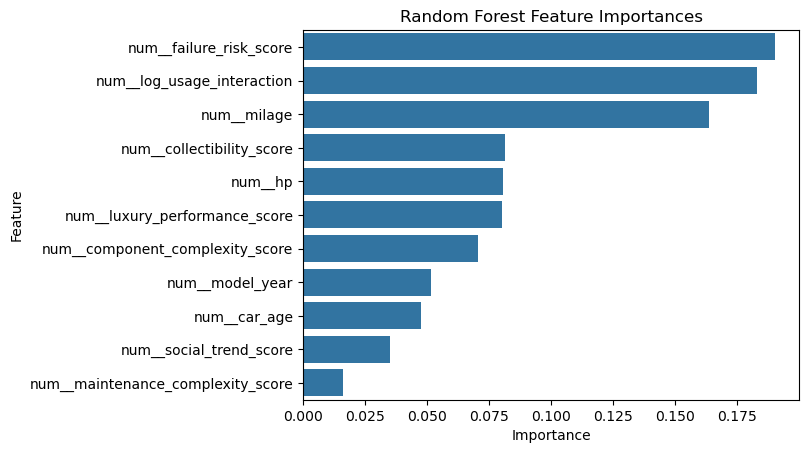

XGBoost - R^2: 0.13004404306411743, MAE: 16345.445676144165, RMSE: 66424.29307166325


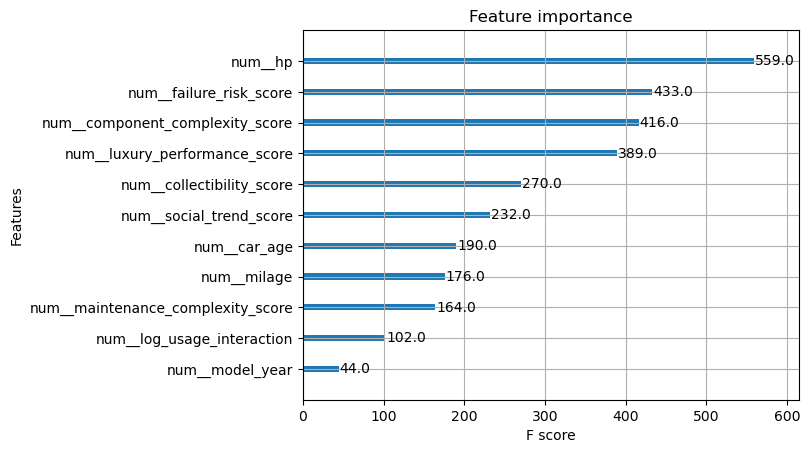

In [97]:
# **OLS Regression and Outlier Treatment**

# Add constant for OLS
X_train_with_constant = add_constant(X_train_selected)
X_test_with_constant = add_constant(X_test_selected)

# Fit base OLS model
ols_model = OLS(y_train, X_train_with_constant).fit()
print(ols_model.summary())

# Calculate Cook's Distance for outlier detection
influence = ols_model.get_influence()
cooks_d = influence.cooks_distance[0]

# Flag outliers based on Cook's Distance
threshold = 4 / len(y_train)
outliers = cooks_d > threshold

# Ensure filtering is done on the correct dataset
X_train_filtered = X_train_selected[~outliers]
y_train_filtered = y_train[~outliers]

# Refit OLS model after outlier removal
X_train_filtered_with_constant = add_constant(X_train_filtered)
ols_model_refined = OLS(y_train_filtered, X_train_filtered_with_constant).fit()
print(ols_model_refined.summary())

# Calculate R-squared, MAE, and RMSE for both models
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)     
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))     
    r2 = r2_score(y_true, y_pred)     
    return mae, rmse, r2 

# Original model 
y_pred_og = ols_model.predict(X_test_with_constant)
mae_og, rmse_og, r_squared_og = evaluate_model(y_test, y_pred_og)
print(f"Original Model - R^2: {r_squared_og}, MAE: {mae_og}, RMSE: {rmse_og}")

# Refined model 
y_pred_ref = ols_model_refined.predict(X_test_with_constant)
mae_ref, rmse_ref, r_squared_ref = evaluate_model(y_test, y_pred_ref)
print(f"Refined Model - R^2: {r_squared_ref}, MAE: {mae_ref}, RMSE: {rmse_ref}")

# **ElasticNet Regression**

# ElasticNet with cross-validation
elastic_net_model = ElasticNetCV(
    l1_ratio=np.linspace(0.1, 0.5, 11),
    alphas=np.linspace(0.01, 0.1, 10),
    cv=5, random_state=2024
)
elastic_net_model.fit(X_train_filtered, y_train_filtered)

# Evaluate ElasticNet model
y_pred_en = elastic_net_model.predict(X_test_selected)
mae_en, rmse_en, r_squared_en = evaluate_model(y_test, y_pred_en)
print(f"ElasticNet - R^2: {r_squared_en}, MAE: {mae_en}, RMSE: {rmse_en}")

# **Random Forest**

# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=300, max_features='sqrt', random_state=2024)
rf_model.fit(X_train_filtered, y_train_filtered)

# Evaluate Random Forest model
y_pred_rf = rf_model.predict(X_test_selected)
mae_rf, rmse_rf, r_squared_rf = evaluate_model(y_test, y_pred_rf)
print(f"Random Forest - R^2: {r_squared_rf}, MAE: {mae_rf}, RMSE: {rmse_rf}")

# Feature importance
rf_importances = pd.DataFrame({'Feature': X_train_filtered.columns.tolist(), 'Importance': rf_model.feature_importances_})
rf_importances.sort_values(by='Importance', ascending=False, inplace=True)
sns.barplot(x='Importance', y='Feature', data=rf_importances)
plt.title('Random Forest Feature Importances')
plt.show()

# **XGBoost**

# Prepare data for XGBoost
dtrain = xgb.DMatrix(data=X_train_filtered, label=y_train_filtered)
dtest = xgb.DMatrix(data=X_test_selected, label=y_test)

# Set XGBoost parameters
xgb_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train XGBoost model with cross-validation
# setting early_stopping_rounds
# try nfold
xgb_cv = xgb.cv(params=xgb_params, dtrain=dtrain, num_boost_round=200, nfold=3, early_stopping_rounds=10, metrics='rmse') 
best_nrounds = len(xgb_cv)

xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=best_nrounds)

# Evaluate XGBoost model
y_pred_xgb = xgb_model.predict(dtest)
mae_xgb, rmse_xgb, r_squared_xgb = evaluate_model(y_test, y_pred_xgb)
print(f"XGBoost - R^2: {r_squared_xgb}, MAE: {mae_xgb}, RMSE: {rmse_xgb}")

# Feature importance
xgb.plot_importance(xgb_model)
plt.show()

In [107]:
# Calculate Coefficient of Variation (CV)
test_mean = y_test.mean()
test_std = y_test.std()
cv = test_std / test_mean * 100
cv

171.415407787591

- CV is approximately 171%, indicating very high variability
- The standard deviation is very large compared to the mean value of the data
- There is significant variation in used car prices within the test data
- This indicates the imbalance in used car prices
- -> This implies difficulty in model prediction, and such high variability needs to be considered when evaluating model performance

In [106]:
# Calculate Mean Relative Error Rate
mean_y = y_test.mean()  # 약 3,808
relative_rmse = (rmse_xgb / mean_y) * 100
relative_mae = (mae_xgb / mean_y) * 100

relative_rmse, relative_mae

(159.87938692479239, 39.34253136717637)

- Mean relative error rate is approximately 39-160%
- This means that the predicted values differ from the actual values by about 39-160% on average
- -> Due to the large variation in used car prices, this result may be inevitable

# Cross-Validation & Bootstrapping
- Apply cross-validation and bootstrapping to the final selected model
- To ensure better generalization, check the model's performance through cross-validation and bootstrapping

### Cross-Validation

XGBoost - R^2: 0.13004404306411743, MAE: 16345.445676144165, RMSE: 66424.29307166325


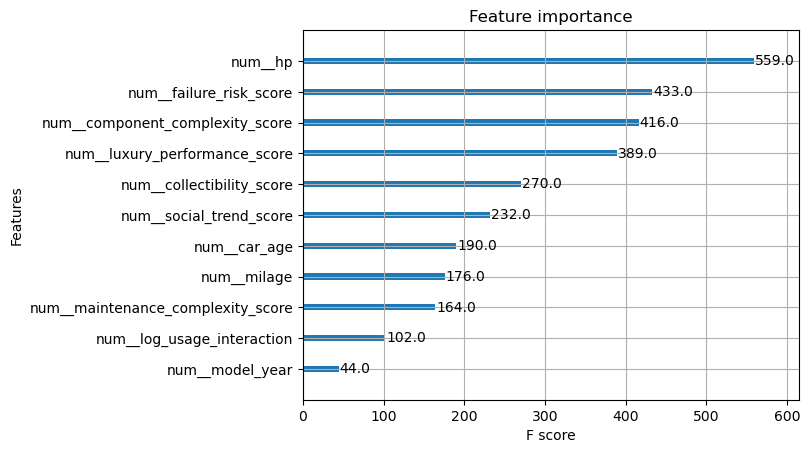

Cross-Validated RMSE: 20237.549745902314


In [103]:
# XGBRegressor
xgb_model = XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',
    eta=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=best_nrounds
)

# Train the XGBoost model
xgb_model.fit(X_train_filtered, y_train_filtered)

# Evaluate model performance
y_pred_xgb = xgb_model.predict(X_test_selected)
mae_xgb, rmse_xgb, r_squared_xgb = evaluate_model(y_test, y_pred_xgb)
print(f"XGBoost - R^2: {r_squared_xgb}, MAE: {mae_xgb}, RMSE: {rmse_xgb}")

# Plot feature importance
xgb.plot_importance(xgb_model, importance_type='weight')
plt.show()

# Perform cross-validation
# cv_scores = cross_val_score(xgb_model, X_train_filtered, y_train_filtered, cv=5, scoring='neg_mean_squared_error')
# cv_rmse = np.sqrt(-cv_scores.mean())
# print(f"Cross-Validated RMSE: {cv_rmse}")

# cross_val_score internally fits the model multiple times
# Even if the passed model is already fit, it will be retrained, so it is recommended to pass a new model instance for clarity and safety
# Initialize a new XGBRegressor for cross-validation
cv_xgb_model = XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',
    eta=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=best_nrounds
)

# Cross-validation
cv_scores = cross_val_score(cv_xgb_model, X_train_filtered, y_train_filtered, 
                             cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())
print(f"Cross-Validated RMSE: {cv_rmse}")

The Cross-Validated RMSE of 20089.41326685806 suggests some variability in performance. 

Potential reasons and solutions:
- The number of folds (cv=5) might contribute to variability.
- Different random states used for splitting the data might have led to different results

1) Overfitting concerns:
    - Cross-validation is performed on the training data, providing performance metrics that are more suited to the training data distribution.
    - The RMSE values calculated in cross-validation are averaged across folds, which might result in relatively lower values compared to independent test evaluations.
    - Cross-validation reflects performance optimized for the training data, which could differ from independent test performance.

2) Hyperparameter tuning:
    - Instead of relying solely on cross-validation results, it is appropriate to search for hyperparameters that perform well on independent test data.

3) Ensemble methods:
    - Using techniques like bootstrapping or bagging to stabilize model performance.
    - Can help in reducing the impact of variability and improving generalization.

### Bootstrapping
To ensure better generalization and evaluate the model's performance, appling bootstrapping
- calculating the mean and standard deviation of the RMSE to assess the uncertainty in the model's performance
- after evaluating the model's performance, provide prediction confidence intervals for the final model
    - presenting confidence intervals for specific predictions can help users make better decisions
    - for example, we can explain that there is a 95% probability that the price of a specific vehicle will be between 20,000 and 22,000.

In [104]:
# Bootstrapping

# Set up bootstrap
n_iterations = 1000
bootstrap_rmse = []
bootstrap_preds = np.zeros((n_iterations, len(y_test)))

# Perform bootstrap iterations
for i in range(n_iterations):
    # Resample the training data using bootstrap sampling
    X_resampled, y_resampled = resample(X_train_filtered, y_train_filtered, random_state=i)
    
    # Initialize a new model and train (each iteration)
    bootstrap_model = XGBRegressor(
        booster='gbtree',
        objective='reg:squarederror',
        eta=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=best_nrounds
    )
    bootstrap_model.fit(X_resampled, y_resampled)
    
    # Predict using the test data
    y_pred_bootstrap = bootstrap_model.predict(X_test_selected)
    
    # Compute RMSE and save the result
    rmse_bootstrap = np.sqrt(mean_squared_error(y_test, y_pred_bootstrap))
    bootstrap_rmse.append(rmse_bootstrap)
    
    # Store predictions from each iteration
    bootstrap_preds[i, :] = y_pred_bootstrap

# Compute mean and standard deviation of RMSE
bootstrap_rmse_mean = np.mean(bootstrap_rmse)
bootstrap_rmse_std = np.std(bootstrap_rmse)

print(f"Bootstrap RMSE: {bootstrap_rmse_mean} ± {bootstrap_rmse_std}")

# Compute confidence intervals (95% confidence interval)
bootstrap_mean = np.mean(bootstrap_preds, axis=0)
bootstrap_ci_lower = np.percentile(bootstrap_preds, 2.5, axis=0)
bootstrap_ci_upper = np.percentile(bootstrap_preds, 97.5, axis=0)

print(f"Bootstrap Mean Prediction: {bootstrap_mean}")
print(f"95% Confidence Interval: [{bootstrap_ci_lower}, {bootstrap_ci_upper}]")

Bootstrap RMSE: 66431.73674460598 ± 19.45903009716405
Bootstrap Mean Prediction: [58747.98474609 68697.07107812  8241.04027734 ... 29686.81164648
 53353.70176563 58173.77899609]
95% Confidence Interval: [[56516.56962891 63192.653125    7973.05380859 ... 27544.10761719
 50828.97158203 54477.21103516], [61202.17089844 74458.92714844  8501.56062012 ... 31705.76616211
 56085.01132813 62030.36953125]]


In [ ]:
# Apply parallel computing for faster bootstrapping

from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Set up bootstrap
n_iterations = 1000
bootstrap_rmse = []
bootstrap_preds = np.zeros((n_iterations, len(y_test)))

# Function to perform a single bootstrap iteration
def bootstrap_iteration(i):
    # Resample the training data using bootstrap sampling
    X_resampled, y_resampled = resample(X_train_filtered, y_train_filtered, random_state=i)
    
    # Initialize a new model and train (each iteration)
    bootstrap_model = RandomForestRegressor(
        n_estimators=100, 
        max_features='sqrt', 
        random_state=2024,
        n_jobs=-1)
    bootstrap_model.fit(X_resampled, y_resampled)
    
    # Predict using the test data
    y_pred_bootstrap = bootstrap_model.predict(X_test_selected)
    
    # Compute RMSE and save the result
    rmse_bootstrap = np.sqrt(mean_squared_error(y_test, y_pred_bootstrap))
    
    return rmse_bootstrap, y_pred_bootstrap

# Perform bootstrap iterations in parallel with progress tracking
results = Parallel(backend='loky', n_jobs=-1)(delayed(bootstrap_iteration)(i) for i in tqdm(range(n_iterations), leave=True, position=1))

# Extract RMSE and predictions from results
for i, (rmse_bootstrap, y_pred_bootstrap) in enumerate(results):
    bootstrap_rmse.append(rmse_bootstrap)
    bootstrap_preds[i, :] = y_pred_bootstrap

# Compute mean and standard deviation of RMSE
bootstrap_rmse_mean = np.mean(bootstrap_rmse)
bootstrap_rmse_std = np.std(bootstrap_rmse)

print(f"Bootstrap RMSE: {bootstrap_rmse_mean} ± {bootstrap_rmse_std}")

# Compute confidence intervals (95% confidence interval)
bootstrap_mean = np.mean(bootstrap_preds, axis=0)
bootstrap_ci_lower = np.percentile(bootstrap_preds, 2.5, axis=0)
bootstrap_ci_upper = np.percentile(bootstrap_preds, 97.5, axis=0)

print(f"Bootstrap Mean Prediction: {bootstrap_mean}")
print(f"95% Confidence Interval: [{bootstrap_ci_lower}, {bootstrap_ci_upper}]")


  1%|▍                                       | 11/1000 [00:00<00:09, 109.47it/s]